### # 241,010,102       : 기저귀

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import seaborn as sns

In [3]:
import os
os.getcwd()

'/Users/we/Downloads/업무/buy it again_분석 '

./chunk/

---

In [4]:
diaper_train = pd.read_excel('diaper_train.xlsx')
diaper_test = pd.read_excel('diaper_test.xlsx')

In [12]:
diaper_train.head(3)

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
105,105,2018-01-01 00:00:26,"6,200,018","34,900","1,472,659","241,010,102",1
212,212,2018-01-01 00:00:52,"2,683,481","32,000","1,597,856","241,010,102",1
2357,2357,2018-01-01 00:03:47,"3,579,286","104,700","1,766,436","241,010,102",1


In [13]:
diaper_train.m_id.nunique()   # 약 20만명(31~32주 동안)

212550

In [14]:
train_mid = diaper_train.m_id.unique()

In [15]:
diaper_train[diaper_train.m_id == train_mid[0]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
105,105,2018-01-01 00:00:26,"6,200,018","34,900","1,472,659","241,010,102",1
3125,3125,2018-01-01 00:04:27,"6,200,018","34,900","1,472,659","241,010,102",1
732522,10732522,2018-01-24 09:44:17,"6,200,018","15,800","3,201,607","241,010,102",1


---

### #  time interval 불러오기

In [5]:
tt = pd.read_csv('diaper_t.csv')

In [6]:
tt.head()

,Unnamed: 0,0
0,0,NaN
1,1,0.0
2,2,23.0
3,3,NaN
4,4,59.0


In [7]:
tt = tt.iloc[:,1:]

In [8]:
# 데이터 확인

tt.tail(10)   # 음 ... 꼬리에는 구매 데이터가 없으니깐 그런가봐

,0
545765,NaN
545766,NaN
545767,NaN
545768,NaN
545769,NaN
545770,NaN
545771,NaN
545772,NaN
545773,NaN
545774,NaN


In [9]:
tt.shape   # 54만개의 time interval

(545775, 1)

In [10]:
tt.count()   # 0인 관측치 제외하고, 33만개의 데이터

0    333225
dtype: int64

In [11]:
len(tt)-tt.count()  # 54만개 중, 약 21만개가 distinct user : datetime.diff() 메소드 이용하면, 첫번째 obs는 nan이 되니깐 맞아!

0    212550
dtype: int64

In [12]:
# train 데이터 확인

diaper_train.shape

(545775, 7)

In [13]:
# unique한 멤버 몇 명?

diaper_train.m_id.unique().shape

(212550,)

- 확인!

In [14]:
diaper_train.m_id.nunique()

212550

---

# # t (interval) 분석해보자

In [15]:
tt.shape

(545775, 1)

In [16]:
tt = tt.dropna()  # t값 순수하게 얻은거야

In [17]:
# nan값 제거하고 얻은 shape

tt.shape

(333225, 1)

In [18]:
tt.head()

,0
1,0.0
2,23.0
4,59.0
5,0.0
6,31.0


In [19]:
# time 으로 column명 변경
tt.columns = ['time']

In [20]:
tt.head(5)

,time
1,0.0
2,23.0
4,59.0
5,0.0
6,31.0


In [22]:
#음.. 여기도 0인값이 많구나? - 여러가지 이유로 많이 집계되었겠지만(한번에 여러번 구매했는데, 따로따로 들어가 있을 수 있고!), 그래도 무려 5만개야!

tt.time.value_counts()

0.0      57461
14.0      6597
20.0      6597
21.0      6572
15.0      6335
17.0      6236
18.0      6232
13.0      6209
19.0      6181
27.0      6042
16.0      5940
28.0      5882
22.0      5860
23.0      5682
26.0      5579
24.0      5531
12.0      5476
25.0      5429
29.0      5348
1.0       4994
11.0      4833
30.0      4809
10.0      4765
31.0      4498
9.0       4374
8.0       4236
32.0      4166
7.0       4122
33.0      4075
2.0       4018
         ...  
176.0       45
185.0       38
193.0       37
180.0       35
184.0       34
175.0       34
186.0       30
191.0       27
190.0       26
192.0       26
187.0       25
194.0       24
189.0       24
188.0       24
197.0       21
199.0       21
204.0       18
196.0       16
200.0       15
198.0       13
195.0       13
202.0       13
201.0       12
203.0       11
206.0        9
205.0        7
210.0        6
209.0        5
207.0        5
208.0        3
Name: time, Length: 211, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b267828>]],
      dtype=object)

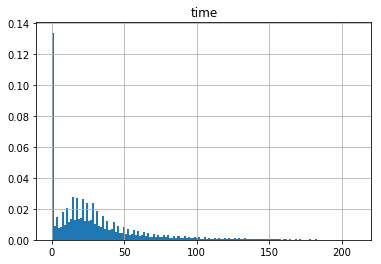

In [17]:
# time=0 인 값이 너무 많아보여서, histogram으로 다시 한번.

pd.DataFrame(tt).hist(bins=150, density = True)

histogram : 와... 0이 너무많아!

In [18]:
tmean = tt.mean()

In [19]:
# 0을 포함했을때의 평균.. 어느정도 될까?

tmean

time    29.54763
dtype: float64

## # drop 0 value - 아무래도, 같은 카테고리의 제품을 장바구니에 같이넣어서 한꺼번에 구매한거니깐!

In [23]:
# 0인것을 드랍하는 작업!

tt_drop0 = tt[(tt[['time']] != 0).all(axis=1)]

---

In [28]:
# 무슨 원리일까?

tt[['time']] != 0

,time
1,False
2,True
4,True
5,False
6,True
7,True
8,True
9,True
11,True
14,True


In [41]:
(tt[['time']] != 0).all(axis=1)

1         False
2          True
4          True
5         False
6          True
7          True
8          True
9          True
11         True
14         True
15         True
17         True
19         True
20         True
23        False
24         True
27         True
28         True
29         True
31         True
32         True
33         True
34         True
36         True
38         True
39         True
40         True
41         True
44        False
46         True
          ...  
545488    False
545503    False
545504    False
545505    False
545517    False
545523    False
545529    False
545532    False
545540    False
545548    False
545557    False
545558    False
545565    False
545566    False
545567    False
545584    False
545595    False
545613    False
545639    False
545640    False
545655    False
545673    False
545677    False
545678    False
545687    False
545688    False
545712    False
545718    False
545724    False
545749    False
Length: 333225, dtype: b

In [42]:
tt.time != 0

1         False
2          True
4          True
5         False
6          True
7          True
8          True
9          True
11         True
14         True
15         True
17         True
19         True
20         True
23        False
24         True
27         True
28         True
29         True
31         True
32         True
33         True
34         True
36         True
38         True
39         True
40         True
41         True
44        False
46         True
          ...  
545488    False
545503    False
545504    False
545505    False
545517    False
545523    False
545529    False
545532    False
545540    False
545548    False
545557    False
545558    False
545565    False
545566    False
545567    False
545584    False
545595    False
545613    False
545639    False
545640    False
545655    False
545673    False
545677    False
545678    False
545687    False
545688    False
545712    False
545718    False
545724    False
545749    False
Name: time, Length: 3332

In [43]:
# tt[['time']] 은 데이터프레임 - 열이 하나일때는 이렇게 해도 되나봐

tt[tt.time != 0] 

,time
2,23.0
4,59.0
6,31.0
7,23.0
8,60.0
9,8.0
11,53.0
14,148.0
15,32.0
17,29.0


---

In [21]:
tt_drop0.head()

,time
2,23.0
4,59.0
6,31.0
7,23.0
8,60.0


In [25]:
tt_drop0.time.value_counts()

20.0     6597
14.0     6597
21.0     6572
15.0     6335
17.0     6236
18.0     6232
13.0     6209
19.0     6181
27.0     6042
16.0     5940
28.0     5882
22.0     5860
23.0     5682
26.0     5579
24.0     5531
12.0     5476
25.0     5429
29.0     5348
1.0      4994
11.0     4833
30.0     4809
10.0     4765
31.0     4498
9.0      4374
8.0      4236
32.0     4166
7.0      4122
33.0     4075
2.0      4018
34.0     3960
         ... 
176.0      45
185.0      38
193.0      37
180.0      35
184.0      34
175.0      34
186.0      30
191.0      27
190.0      26
192.0      26
187.0      25
194.0      24
189.0      24
188.0      24
197.0      21
199.0      21
204.0      18
196.0      16
200.0      15
198.0      13
195.0      13
202.0      13
201.0      12
203.0      11
206.0       9
205.0       7
210.0       6
209.0       5
207.0       5
208.0       3
Name: time, Length: 210, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cd32cf8>]],
      dtype=object)

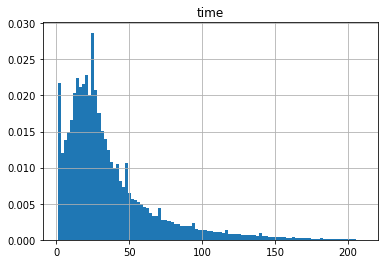

In [32]:
tt_drop0.hist(bins=100, density = True)

In [49]:
#0인 관측치들 제외하고, 평균 약 35일

tt_drop0.mean()

time    35.704476
dtype: float64

### # tt_drop0drop1 : 1일만에 재주문한 애들도 제외!

In [27]:
tt_drop0drop1 = tt_drop0[tt_drop0.time != 1 ]

In [29]:
tt_drop0drop1.time.value_counts()

20.0     6597
14.0     6597
21.0     6572
15.0     6335
17.0     6236
18.0     6232
13.0     6209
19.0     6181
27.0     6042
16.0     5940
28.0     5882
22.0     5860
23.0     5682
26.0     5579
24.0     5531
12.0     5476
25.0     5429
29.0     5348
11.0     4833
30.0     4809
10.0     4765
31.0     4498
9.0      4374
8.0      4236
32.0     4166
7.0      4122
33.0     4075
2.0      4018
34.0     3960
6.0      3873
         ... 
176.0      45
185.0      38
193.0      37
180.0      35
184.0      34
175.0      34
186.0      30
191.0      27
190.0      26
192.0      26
187.0      25
194.0      24
189.0      24
188.0      24
197.0      21
199.0      21
204.0      18
196.0      16
200.0      15
198.0      13
195.0      13
202.0      13
201.0      12
203.0      11
206.0       9
205.0       7
210.0       6
209.0       5
207.0       5
208.0       3
Name: time, Length: 209, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cca3f98>]],
      dtype=object)

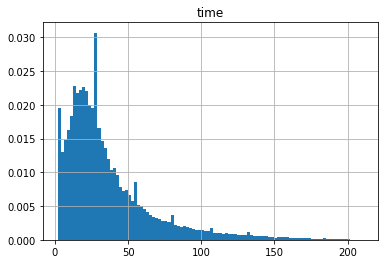

In [31]:
tt_drop0drop1.hist(bins=100, density = True)  # 그래프가 많이 차이나지는 않네!

---

---

---

# 2. 파라미터 추정

### # (1) gamma.fit으로 parameters 추정해볼게.

In [50]:
stats.gamma.fit(tt_drop0)

(1.353228419999001, 0.5894381309054153, 25.949121566142814)

In [51]:
stats.gamma.fit(tt_drop0, floc=0)  # floc=0 선언해주면, loc parmater 0으로 나오네

(1.4696308007488543, 0, 24.294860687371564)

In [52]:
alpha, _ , scale = stats.gamma.fit(tt_drop0, floc=0)

In [53]:
alpha, _ , scale

(1.4696308007488543, 0, 24.294860687371564)

- <U>(비교) r에서 MASS 패키지로 얻은 값들 : (1.469631198, , ,24.294852175) </U>  -> 그냥 python scipy써도 될 것 같아.

In [55]:
#감마 파라미터로 구한 람다추정치 : 35일정도?(샘플 평균이랑 비슷하네)

1.4696308007488543*24.294860687371564

35.704475566063735

---

: 추정된 parameters로 분포 확인해볼게

In [34]:
y = stats.gamma.rvs(a = alpha , scale=scale , size = tt_drop0.shape[0])

In [35]:
y

array([47.75617851, 68.0270532 , 31.15057331, ..., 26.69991408,
       52.34197908, 58.18975447])

In [36]:
y.mean()

35.80248077655221

In [37]:
import seaborn as sns

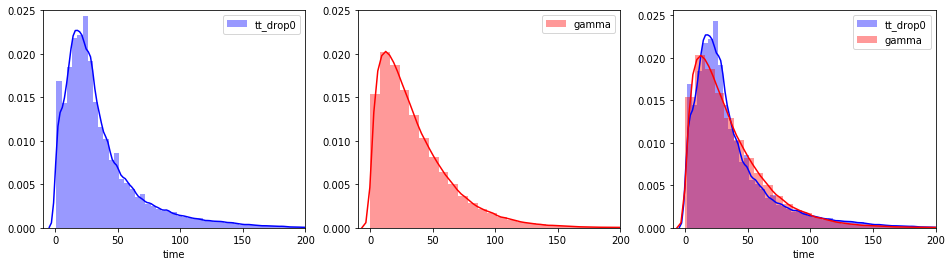

In [38]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
sns.distplot(tt_drop0.time, color = 'blue', label='tt_drop0')
plt.legend()
plt.xlim(-10,200)
plt.ylim(0,0.025)

plt.subplot(1,3,2)
sns.distplot(y, color = 'red', label='gamma')
plt.legend()
plt.xlim(-10,200)
plt.ylim(0,0.025)

plt.subplot(1,3,3)
sns.distplot(tt_drop0.time, color = 'blue', label='tt_drop0')
sns.distplot(y, color = 'red', label='gamma')
plt.legend()
plt.xlim(-10,200)

plt.show()
plt.close()

---

---

# 3. MPG

In [ ]:
train

In [49]:
diaper_train[10:11].m_id.tolist()[0]

'23,169,163'

In [57]:
diaper_train[10:11].m_id.values

array(['23,169,163'], dtype=object)

In [61]:
diaper_train[10:11].m_id.item()

'23,169,163'

In [43]:
diaper_train[diaper_train.m_id == test_id[10]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd


---

# test id 데이터에서 뽑아오자

In [45]:
# Test_id : 테스트 데이터에서, unique한 id 1000개

test_id = diaper_test.m_id.unique()[:1000]

In [46]:
len(test_id)

1000

In [47]:
# 마지막 테스트 아이디 확인 

diaper_test[diaper_test.m_id == test_id[1000-1]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
9313038,99313038,2018-08-01 10:47:51,"22,776,930","29,900","3,368,595","241,010,102",1


---

In [48]:
# 마지막 테스트 아이디의 train기간 중 구매내역

diaper_train[diaper_train.m_id == test_id[11-1]].shape[0] == False

True

In [49]:
diaper_train[diaper_train.m_id == test_id[10]].shape[0]

0

In [50]:
diaper_test[diaper_test.m_id == test_id[10]].shape[0]

3

In [51]:
(diaper_train[diaper_train.m_id == test_id[10]].shape[0])&(diaper_test[diaper_test.m_id == test_id[10]].shape[0])

0

In [52]:
# test_id 1000개중에서, train기록 가지고있는 애들만 활용해본다!

tf = []
for i in range(len(test_id)):
    tf.append( bool(diaper_train[diaper_train.m_id == test_id[i]].shape[0]) 
              & bool(diaper_test[diaper_test.m_id == test_id[i]].shape[0]) == True) #train, test 둘다 있는 아이디를 밝혀주는 index만들어주는거야.

In [53]:
tf

[True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 Tr

In [54]:
len(test_id)

1000

In [56]:
len(test_id[tf]) # train data를 가지고있는 애들(70% 정도네!)

754

In [57]:
test_id_ = test_id[tf]

In [58]:
test_id_

array(['4,379,895', '18,718,496', '14,501,395', '18,420,575',
       '12,045,031', '17,606,587', '12,020,579', '8,230,704', '8,687,886',
       '3,631,689', '1,997,580', '8,474,335', '17,284,517', '4,004,349',
       '6,642,473', '4,190,869', '10,124,973', '5,600,959', '5,738,434',
       '2,941,752', '3,461,535', '3,948,988', '5,535,410', '7,544,089',
       '11,078,829', '1,765,930', '6,478,239', '6,327,002', '12,067,634',
       '19,931,056', '10,234,198', '23,565,731', '12,605,729',
       '24,772,167', '8,101,654', '13,483,136', '1,409,782', '22,964,786',
       '10,087,861', '4,278,997', '21,271,410', '13,143,846',
       '16,124,205', '5,342,189', '1,176,711', '3,216,380', '20,138,564',
       '19,307,245', '1,481,974', '10,788,008', '2,521,937', '9,368,549',
       '3,070,193', '10,796,693', '16,847,429', '12,361,719',
       '10,341,727', '8,391,501', '20,818,701', '2,483,854', '8,226,164',
       '21,869,594', '3,389,351', '1,253,642', '4,151,822', '5,656,872',
       '18,073

---

## # test_id[0] 로 흐름따라가보자~

### # t_ : elapsed time interval(the last purchase  by the customer and the current time:

In [121]:
bbfood_test[bbfood_test.m_id == test_id[0]].iloc[0].biz_dt    # test_data에서 첫 구매

Timestamp('2018-08-01 00:00:31')

In [122]:
bbfood_train[bbfood_train.m_id == test_id[0]].iloc[-1].biz_dt  

Timestamp('2018-07-13 23:12:00')

---

In [104]:
current = pd.to_datetime('2018-08-01')

In [110]:
# test_id_ 의 첫번째 user의 구매기록을 살펴볼게
diaper_train[diaper_train.m_id == test_id_[0]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
26387,26387,2018-01-01 00:26:17,"8,230,704","57,500","1,656,921","241,010,102",1
4035278,14035278,2018-02-01 00:09:06,"8,230,704","57,500","1,656,921","241,010,102",1
5853334,25853334,2018-03-01 00:41:34,"8,230,704","57,500","1,656,921","241,010,102",1


In [106]:
# test_id_ 첫번째 user의 elapsed time 이야.

t_ = (current - diaper_train[diaper_train.m_id == test_id_[0]].iloc[-1].biz_dt).days

In [107]:
t_

152

---

### #  t_purch : elapsed time between first and last purcahse time 

In [126]:
t_purch = (bbfood_train[bbfood_train.m_id == test_id[0]].iloc[-1].biz_dt - bbfood_train[bbfood_train.m_id == test_id[0]].iloc[0].biz_dt).days

### # aggregation t_mean

In [144]:
tmean = tt_drop0.time.mean()

In [145]:
tmean

21.6096990088871

### # user's  t_mean

In [129]:
tmean_user = bbfood_train.biz_dt[bbfood_train.m_id == test_id[0]].diff().mean().days

In [130]:
tmean_user

4

In [132]:
theta_, k_

(16.963438276425805, 1.2738985255670858)

In [133]:
current

Timestamp('2018-08-01 00:00:00')

In [134]:
(k+k_)/(t_purch+2*abs(tmean_user-tmean)+(1/theta_))

time    0.124813
dtype: float64

- current가 7월17일이라면?

In [ ]:
current = pd.to_datetime('2018-07-17')

In [125]:
current = pd.to_datetime('2018-08-01')

---

## # modified lambda function

In [111]:
def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

In [126]:
# 우리가 설정한 current

current

Timestamp('2018-08-01 00:00:00')

In [127]:
# 설정한 current에서 한달 정도의 기간을 만들어준다.

current_l = pd.date_range(current, periods=30).tolist()

---

In [115]:
diaper_train[diaper_train.m_id == test_id_[7]]

,Unnamed: 0,biz_dt,m_id,order_price,prod_no,old_admin_category_id,serv_cd
7918612,77918612,2018-06-18 07:32:48,"6,327,002","47,800","1,668,329","241,010,102",1


In [189]:
1-stats.poisson.pmf(mu = lamb, k=0)

0.048510003067078644

In [117]:
alpha  # shape

1.4696308007488543

In [118]:
scale   # scale

24.294860687371564

In [122]:
tt_drop0.mean().item()

35.704475566063735

In [119]:
tmean

time    29.54763
dtype: float64

In [130]:
# 이 사람의 Train 데이터에서의 마지막구매!

diaper_train.biz_dt[diaper_train.m_id == test_id_[0]][-1:]

5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]

In [133]:
# test_id[0] 의 8월 한달간 구매율 예측...?

for j in range(len(test_id_)):
    for i in range(30):
        lamb, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha , beta=1/scale , tmean=tt_drop0.mean().item() , current=current_l[i])
        
        if i == 0:
            print('last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:])
        print('current:',current_l[i], ', pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k)
    
    print('------------------------------------------------------------------------')
    print('\n')

last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.014545723582941927 , tmean_u: 29 , k: 3
current: 2018-08-02 00:00:00 , pred: 0.014451663835985729 , tmean_u: 29 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.014358812724490577 , tmean_u: 29 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.014267147101750477 , tmean_u: 29 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.014176644408347316 , tmean_u: 29 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.014087282653641453 , tmean_u: 29 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.013999040397959517 , tmean_u: 29 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.013911896735446905 , tmean_u: 29 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.013825831277556322 , tmean_u: 29 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.013740824137145613 , tmean_u: 29 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.013656855913159127 , tmean_u: 29 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.01357390767586

current: 2018-08-02 00:00:00 , pred: 0.028598904490925836 , tmean_u: 66 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.028237573643841274 , tmean_u: 66 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.02788525868687808 , tmean_u: 66 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.02754162635507218 , tmean_u: 66 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.027206359607621078 , tmean_u: 66 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.026879156652528824 , tmean_u: 66 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.026559730040774276 , tmean_u: 66 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.026247805824286985 , tmean_u: 66 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.025943122772551508 , tmean_u: 66 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.0256454316431296 , tmean_u: 66 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.02535449450182159 , tmean_u: 66 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.025070084088570366 , tmean_u: 66 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.024791983225557535

current: 2018-08-05 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.09539800898549466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.08856133345034045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.08263842920251074 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.07745767691851246 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.07288787962531029 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.06882702918324823 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.06519462001948195 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.061926269189229166 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.05896987415237609 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.05628281898695264 , 

current: 2018-08-29 00:00:00 , pred: 0.049513949144170954 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.04760544749407547 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 9742468   2018-06-01 07:35:15
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.03759217609798504 , tmean_u: 25 , k: 7
current: 2018-08-02 00:00:00 , pred: 0.03726144878599513 , tmean_u: 25 , k: 7
current: 2018-08-03 00:00:00 , pred: 0.036936489354705504 , tmean_u: 25 , k: 7
current: 2018-08-04 00:00:00 , pred: 0.03661714823884821 , tmean_u: 25 , k: 7
current: 2018-08-05 00:00:00 , pred: 0.036303280999334664 , tmean_u: 25 , k: 7
current: 2018-08-06 00:00:00 , pred: 0.035994748105530716 , tmean_u: 25 , k: 7
current: 2018-08-07 00:00:00 , pred: 0.035691414728532544 , tmean_u: 25 , k: 7
current: 2018-08-08 00:00:00 , pred: 0.03539315054480374 , tmean_u: 25 , k: 7
current: 2018-08-09 00:00:00 ,

current: 2018-08-02 00:00:00 , pred: 0.0370300057540216 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.03817465849056256 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.0393923243186004 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.0406902181461084 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.042076537702766426 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.04356063676018884 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.04515323631887169 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.046866683836316314 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.048715273745538634 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.05071564685927632 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.05288729227324085 , t

last order: 1428224   2018-05-13 22:42:37
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.02810458088861001 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.02747919182166292 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.02688102776957446 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.02630834893321843 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.02575956065414642 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.025233198589416084 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.024727915667094758 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.024242470577820807 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.023775717595471924 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.02332659755124844 , tmean_u: 35.7

current: 2018-08-03 00:00:00 , pred: 0.282146004335604 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.36436701238135516 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.511204831627803 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.8178749956210087 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.979886150821918 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.4132421814358209 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.7

current: 2018-08-07 00:00:00 , pred: 0.050054602045075614 , tmean_u: 0 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.048958287221922414 , tmean_u: 0 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.04790895722028321 , tmean_u: 0 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.046903655558627855 , tmean_u: 0 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.04593966865682131 , tmean_u: 0 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.045014501397325546 , tmean_u: 0 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.044125855578244666 , tmean_u: 0 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.043271610866786214 , tmean_u: 0 , k: 3
current: 2018-08-15 00:00:00 , pred: 0.04244980792110076 , tmean_u: 0 , k: 3
current: 2018-08-16 00:00:00 , pred: 0.04165863339790665 , tmean_u: 0 , k: 3
current: 2018-08-17 00:00:00 , pred: 0.04089640660462024 , tmean_u: 0 , k: 3
current: 2018-08-18 00:00:00 , pred: 0.040161567589353964 , tmean_u: 0 , k: 3
current: 2018-08-19 00:00:00 , pred: 0.039452666491291755 , tmean_u: 

current: 2018-08-10 00:00:00 , pred: 0.045066295272797596 , tmean_u: 24 , k: 9
current: 2018-08-11 00:00:00 , pred: 0.04545756751384433 , tmean_u: 24 , k: 9
current: 2018-08-12 00:00:00 , pred: 0.045855692138815685 , tmean_u: 24 , k: 9
current: 2018-08-13 00:00:00 , pred: 0.04626085071189612 , tmean_u: 24 , k: 9
current: 2018-08-14 00:00:00 , pred: 0.04667323126752576 , tmean_u: 24 , k: 9
current: 2018-08-15 00:00:00 , pred: 0.04709302860114828 , tmean_u: 24 , k: 9
current: 2018-08-16 00:00:00 , pred: 0.0475204445757752 , tmean_u: 24 , k: 9
current: 2018-08-17 00:00:00 , pred: 0.04795568844538067 , tmean_u: 24 , k: 9
current: 2018-08-18 00:00:00 , pred: 0.04839897719621178 , tmean_u: 24 , k: 9
current: 2018-08-19 00:00:00 , pred: 0.04885053590718613 , tmean_u: 24 , k: 9
current: 2018-08-20 00:00:00 , pred: 0.049310598130630656 , tmean_u: 24 , k: 9
current: 2018-08-21 00:00:00 , pred: 0.04977940629471489 , tmean_u: 24 , k: 9
current: 2018-08-22 00:00:00 , pred: 0.050257212129034 , tmean

current: 2018-08-11 00:00:00 , pred: 0.030919280431788154 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.030164045423634045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.02944482275939253 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.028759096806233786 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.02810458088861001 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.02747919182166292 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.02688102776957446 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.02630834893321843 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.02575956065414642 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.025233198589416084 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.02472791566709475

current: 2018-08-08 00:00:00 , pred: 0.01626143613824582 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.016050075390514618 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.015844138422180132 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.01564341911093925 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.015447721648098156 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.015256859901486508 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.01507065682501696 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.014888943910956964 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.01471156068134849 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.01453835421535199 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.0143691787095868

current: 2018-08-06 00:00:00 , pred: 0.036285919654994725 , tmean_u: 30 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.03588344926566922 , tmean_u: 30 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.035489808070300444 , tmean_u: 30 , k: 5
current: 2018-08-09 00:00:00 , pred: 0.03510470871721394 , tmean_u: 30 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.03472787618894213 , tmean_u: 30 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.03435904714753524 , tmean_u: 30 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.033997969321128974 , tmean_u: 30 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.03364440092876941 , tmean_u: 30 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.033298110140739245 , tmean_u: 30 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.0329588745718562 , tmean_u: 30 , k: 5
current: 2018-08-16 00:00:00 , pred: 0.03262648080541597 , tmean_u: 30 , k: 5
current: 2018-08-17 00:00:00 , pred: 0.03230072394564121 , tmean_u: 30 , k: 5
current: 2018-08-18 00:00:00 , pred: 0.03198140719666287 , tm

current: 2018-08-09 00:00:00 , pred: 0.06323482989969853 , tmean_u: 17 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.062022817738064284 , tmean_u: 17 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.06085637722800974 , tmean_u: 17 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.05973298640977631 , tmean_u: 17 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.05865030598041898 , tmean_u: 17 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.05760616305683919 , tmean_u: 17 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.056598536640023345 , tmean_u: 17 , k: 5
current: 2018-08-16 00:00:00 , pred: 0.05562554457617641 , tmean_u: 17 , k: 5
current: 2018-08-17 00:00:00 , pred: 0.054685431837998566 , tmean_u: 17 , k: 5
current: 2018-08-18 00:00:00 , pred: 0.05377655997280373 , tmean_u: 17 , k: 5
current: 2018-08-19 00:00:00 , pred: 0.05289739758418499 , tmean_u: 17 , k: 5
current: 2018-08-20 00:00:00 , pred: 0.052046511731048684 , tmean_u: 17 , k: 5
current: 2018-08-21 00:00:00 , pred: 0.05122256014252624 , t

current: 2018-08-12 00:00:00 , pred: 0.0273729664917558 , tmean_u: 28 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.02704176844759154 , tmean_u: 28 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.02671848873246263 , tmean_u: 28 , k: 3
current: 2018-08-15 00:00:00 , pred: 0.02640284674929616 , tmean_u: 28 , k: 3
current: 2018-08-16 00:00:00 , pred: 0.026094575003248965 , tmean_u: 28 , k: 3
current: 2018-08-17 00:00:00 , pred: 0.0257934183458306 , tmean_u: 28 , k: 3
current: 2018-08-18 00:00:00 , pred: 0.025499133270755925 , tmean_u: 28 , k: 3
current: 2018-08-19 00:00:00 , pred: 0.025211487257442378 , tmean_u: 28 , k: 3
current: 2018-08-20 00:00:00 , pred: 0.024930258158433083 , tmean_u: 28 , k: 3
current: 2018-08-21 00:00:00 , pred: 0.024655233627356 , tmean_u: 28 , k: 3
current: 2018-08-22 00:00:00 , pred: 0.02438621058432311 , tmean_u: 28 , k: 3
current: 2018-08-23 00:00:00 , pred: 0.02412299471594148 , tmean_u: 28 , k: 3
current: 2018-08-24 00:00:00 , pred: 0.023865400007351045 , tmea

current: 2018-08-09 00:00:00 , pred: 0.033820261162189724 , tmean_u: 4 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.033470359948920336 , tmean_u: 4 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.033127623997268096 , tmean_u: 4 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.032791835463967245 , tmean_u: 4 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.03246278524701818 , tmean_u: 4 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.032140272551639426 , tmean_u: 4 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.031824104481825266 , tmean_u: 4 , k: 5
current: 2018-08-16 00:00:00 , pred: 0.03151409565576524 , tmean_u: 4 , k: 5
current: 2018-08-17 00:00:00 , pred: 0.0312100678435151 , tmean_u: 4 , k: 5
current: 2018-08-18 00:00:00 , pred: 0.0309118496254297 , tmean_u: 4 , k: 5
current: 2018-08-19 00:00:00 , pred: 0.030619276069986157 , tmean_u: 4 , k: 5
current: 2018-08-20 00:00:00 , pred: 0.030332188429722517 , tmean_u: 4 , k: 5
current: 2018-08-21 00:00:00 , pred: 0.030050433854115877 , tmean_u: 4

current: 2018-08-11 00:00:00 , pred: 0.0860395390052916 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.09247858099427864 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.09995835351340498 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.10875302499196793 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.11924217219306443 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.13196670886270045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.14772453951385145 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.16774312561543125 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.19401179282066716 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.22997592054050575 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.282146004335604 , tmea

current: 2018-08-09 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.09539800898549466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.08856133345034045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.08263842920251074 , tme

current: 2018-08-06 00:00:00 , pred: 0.034360453158599924 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.03343030077448883 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.0325491757768791 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.03171330176291043 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.030919280431788154 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.030164045423634045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.02944482275939253 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.028759096806233786 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.02810458088861001 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.02747919182166292 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.02688102776957446 

current: 2018-08-04 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.09539800898549466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.08856133345034045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.08263842920251074 , tme

current: 2018-08-02 00:00:00 , pred: 0.04456574978969918 , tmean_u: 33 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.043694559131882915 , tmean_u: 33 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.04285677076510652 , tmean_u: 33 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.042050500112850164 , tmean_u: 33 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.0412740017313209 , tmean_u: 33 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.04052565670440833 , tmean_u: 33 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.039803961384423214 , tmean_u: 33 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.03910751731394546 , tmean_u: 33 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.038435022186734114 , tmean_u: 33 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.03778526172484864 , tmean_u: 33 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.03715710236544745 , tmean_u: 33 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.03654948466465624 , tmean_u: 33 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.035961417337808554 , t

last order: 1158799   2018-07-15 05:28:39
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.0606821543902194 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.0638172260830252 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.06729374272127531 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.07117066913514958 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.07552136827039169 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.08043827844305751 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.0860395390052916 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.09247858099427864 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.09995835351340498 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.10875302499196793 , tmean_u: 35.70447556

current: 2018-08-03 00:00:00 , pred: 0.06741324274530769 , tmean_u: 10 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.06544002031445662 , tmean_u: 10 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.06357898562173325 , tmean_u: 10 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.06182083885725842 , tmean_u: 10 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.06015728009414201 , tmean_u: 10 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.058580878471746756 , tmean_u: 10 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.057084961386419386 , tmean_u: 10 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.055663520209603745 , tmean_u: 10 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.054311129728051966 , tmean_u: 10 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.05302287903197844 , tmean_u: 10 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.05179431199765172 , tmean_u: 10 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.05062137584604143 , tmean_u: 10 , k: 3
current: 2018-08-15 00:00:00 , pred: 0.04950037652761097 , t

current: 2018-08-05 00:00:00 , pred: 0.023775717595471924 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.02332659755124844 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.022894129811530606 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.02247740513165075 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.0220755792760009 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.0216878673102876 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.021313538484748595 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.020951911638158904 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.020602351061821733 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.02026426277071558 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.019937091135794227

current: 2018-08-29 00:00:00 , pred: 0.010837928360045268 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.010743632823486449 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 6514096   2018-07-06 15:53:18
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.10875302499196793 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.11924217219306443 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.13196670886270045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.14772453951385145 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.16774312561543125 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.19401179282066716 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.22997592054050575 , tmean_u: 35.704475566063735 , k: 1

last order: 4220271   2018-04-29 09:39:48
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.023738654619027133 , tmean_u: 38 , k: 3
current: 2018-08-02 00:00:00 , pred: 0.023489159953467564 , tmean_u: 38 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.02324485490741013 , tmean_u: 38 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.023005579234745444 , tmean_u: 38 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.02277117921933247 , tmean_u: 38 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.022541507345750222 , tmean_u: 38 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.02231642198977213 , tmean_u: 38 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.02209578712719562 , tmean_u: 38 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.02187947205977292 , tmean_u: 38 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.02166735115707974 , tmean_u: 38 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.0214593036132521 , tmean_u: 38 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.02125521321760293 , tm

current: 2018-08-03 00:00:00 , pred: 0.022441537690798707 , tmean_u: 13 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.02228692867406934 , tmean_u: 13 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.022134435322359036 , tmean_u: 13 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.02198401450654386 , tmean_u: 13 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.021835624261823172 , tmean_u: 13 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.021689223748695086 , tmean_u: 13 , k: 5
current: 2018-08-09 00:00:00 , pred: 0.0215447732154892 , tmean_u: 13 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.02140223396238783 , tmean_u: 13 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.02126156830686554 , tmean_u: 13 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.021122739550481273 , tmean_u: 13 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.02098571194696419 , tmean_u: 13 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.020850450671532683 , tmean_u: 13 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.020716921791392284 ,

last order: 8388184   2018-06-19 02:54:26
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.09539800898549466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.08856133345034045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.08263842920251074 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.07745767691851246 , tmean_u: 35.70447

current: 2018-08-29 00:00:00 , pred: 0.03625306664838701 , tmean_u: 59 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.03685078929468544 , tmean_u: 59 , k: 3
------------------------------------------------------------------------


last order: 3504331   2018-07-01 10:46:21
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.04139271809023948 , tmean_u: 35 , k: 5
current: 2018-08-02 00:00:00 , pred: 0.04192916297017424 , tmean_u: 35 , k: 5
current: 2018-08-03 00:00:00 , pred: 0.04247969268679397 , tmean_u: 35 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.043044869239441175 , tmean_u: 35 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.04362528492425377 , tmean_u: 35 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.04422156440325642 , tmean_u: 35 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.04362528492425377 , tmean_u: 35 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.043044869239441175 , tmean_u: 35 , k: 5
current: 2018-08-09 00:00:00 , pred: 0.04247969268679397 , tmean_

current: 2018-08-05 00:00:00 , pred: 0.01564341911093925 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.015447721648098156 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.015256859901486508 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.01507065682501696 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.014888943910956964 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.01471156068134849 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.01453835421535199 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.014369178709586872 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.01420389506881281 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.014042370524537384 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.0138844782793506

current: 2018-08-03 00:00:00 , pred: 0.07582917844711623 , tmean_u: 20 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.07764841327966943 , tmean_u: 20 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.07582917844711623 , tmean_u: 20 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.0740931953965267 , tmean_u: 20 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.07243488016881217 , tmean_u: 20 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.07084913701376572 , tmean_u: 20 , k: 5
current: 2018-08-09 00:00:00 , pred: 0.0693313062023152 , tmean_u: 20 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.06787711838975496 , tmean_u: 20 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.06648265459070912 , tmean_u: 20 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.06514431097731688 , tmean_u: 20 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.06385876783620459 , tmean_u: 20 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.06262296212234453 , tmean_u: 20 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.06143406313299116 , tmean_u

current: 2018-08-06 00:00:00 , pred: 0.008699901489825579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.00863903548281253 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.008579015211699126 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.008519823170906715 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.008461442334665725 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.008403856140687949 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.008347048474502738 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.008291003654422924 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.008235706417113242 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.008181141903731426 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.008127295646

current: 2018-08-04 00:00:00 , pred: 0.09650759840091605 , tmean_u: 20 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.10085915588073202 , tmean_u: 20 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.10562122178403177 , tmean_u: 20 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.10085915588073202 , tmean_u: 20 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.09650759840091605 , tmean_u: 20 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.0925157063897466 , tmean_u: 20 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.0888406932313377 , tmean_u: 20 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.085446295015153 , tmean_u: 20 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.08230157411735439 , tmean_u: 20 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.07937997661674445 , tmean_u: 20 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.07665858290540517 , tmean_u: 20 , k: 3
current: 2018-08-15 00:00:00 , pred: 0.07411750685247376 , tmean_u: 20 , k: 3
current: 2018-08-16 00:00:00 , pred: 0.07173941028427033 , tmean_u: 

current: 2018-08-02 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.4132421814358209 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.10337734467517323 , tmean_

last order: 2373843   2018-04-24 22:01:02
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.019620315837279745 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.01931344910381294 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.019016033206653682 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.018727638181859962 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.018447859756609675 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.01817631745863424 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.01791265289017463 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.017656528149995188 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.017407624388848464 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.017165640485405698 , tmean_u: 3

current: 2018-08-03 00:00:00 , pred: 0.05071564685927632 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.05288729227324085 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.05525318381802058 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.05784059509348449 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.0606821543902194 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.0638172260830252 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.06729374272127531 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.07117066913514958 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.07552136827039169 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.08043827844305751 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.0860395390052916 , tmea

last order: 9779299   2018-02-12 13:41:39
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.00921954923049717 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.009151223586306378 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.009083903201374532 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.009017566052647363 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.008952190755705858 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.008887756541783531 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.008824243235769469 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.008761631235147505 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.008699901489825579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.00863903548281253 , tmean_u: 

current: 2018-08-29 00:00:00 , pred: 0.03230072394564121 , tmean_u: 40 , k: 5
current: 2018-08-30 00:00:00 , pred: 0.03198140719666287 , tmean_u: 40 , k: 5
------------------------------------------------------------------------


last order: 7484846   2018-07-28 00:10:07
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.09143593473513101 , tmean_u: 11 , k: 11
current: 2018-08-02 00:00:00 , pred: 0.09279576124449218 , tmean_u: 11 , k: 11
current: 2018-08-03 00:00:00 , pred: 0.09419660965662913 , tmean_u: 11 , k: 11
current: 2018-08-04 00:00:00 , pred: 0.0956403629104875 , tmean_u: 11 , k: 11
current: 2018-08-05 00:00:00 , pred: 0.09712902085501773 , tmean_u: 11 , k: 11
current: 2018-08-06 00:00:00 , pred: 0.09866470945558492 , tmean_u: 11 , k: 11
current: 2018-08-07 00:00:00 , pred: 0.10024969088320868 , tmean_u: 11 , k: 11
current: 2018-08-08 00:00:00 , pred: 0.10188637458687011 , tmean_u: 11 , k: 11
current: 2018-08-09 00:00:00 , pred: 0.10357732946232356 , t

last order: 4707111   2018-07-03 11:44:12
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.14772453951385145 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.16774312561543125 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.19401179282066716 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.22997592054050575 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.282146004335604 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.36436701238135516 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.511204831627803 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.8178749956210087 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.979886150821918 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.7044755660637

current: 2018-08-30 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 3487770   2018-07-19 13:26:31
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.05071564685927632 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.05288729227324085 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.05525318381802058 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.05784059509348449 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.0606821543902194 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.0638172260830252 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.06729374272127531 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.07117066913514958 , tmean_u: 35.704475566063735 , k: 1
cur

current: 2018-08-02 00:00:00 , pred: 0.04954389346014754 , tmean_u: 21 , k: 9
current: 2018-08-03 00:00:00 , pred: 0.04907948914098714 , tmean_u: 21 , k: 9
current: 2018-08-04 00:00:00 , pred: 0.04862370841286279 , tmean_u: 21 , k: 9
current: 2018-08-05 00:00:00 , pred: 0.048176313337241816 , tmean_u: 21 , k: 9
current: 2018-08-06 00:00:00 , pred: 0.04773707464741761 , tmean_u: 21 , k: 9
current: 2018-08-07 00:00:00 , pred: 0.047305771357098014 , tmean_u: 21 , k: 9
current: 2018-08-08 00:00:00 , pred: 0.046882190390000855 , tmean_u: 21 , k: 9
current: 2018-08-09 00:00:00 , pred: 0.04646612622915103 , tmean_u: 21 , k: 9
current: 2018-08-10 00:00:00 , pred: 0.04605738058466868 , tmean_u: 21 , k: 9
current: 2018-08-11 00:00:00 , pred: 0.04565576207892119 , tmean_u: 21 , k: 9
current: 2018-08-12 00:00:00 , pred: 0.04526108594798872 , tmean_u: 21 , k: 9
current: 2018-08-13 00:00:00 , pred: 0.04487317375846722 , tmean_u: 21 , k: 9
current: 2018-08-14 00:00:00 , pred: 0.04449185313869597 , tm

last order: 7648666   2018-06-17 16:32:01
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.025499133270755925 , tmean_u: 65 , k: 3
current: 2018-08-02 00:00:00 , pred: 0.0257934183458306 , tmean_u: 65 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.026094575003248965 , tmean_u: 65 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.02640284674929616 , tmean_u: 65 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.02671848873246263 , tmean_u: 65 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.02704176844759154 , tmean_u: 65 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.0273729664917558 , tmean_u: 65 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.02771237737635024 , tmean_u: 65 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.028060310400340627 , tmean_u: 65 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.028417090590106553 , tmean_u: 65 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.02878305971188344 , tmean_u: 65 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.029158577363427307 , tm

current: 2018-08-03 00:00:00 , pred: 0.0638172260830252 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.06729374272127531 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.07117066913514958 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.07552136827039169 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.08043827844305751 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.0860395390052916 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.09247858099427864 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.09995835351340498 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.10875302499196793 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.11924217219306443 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.13196670886270045 , tme

current: 2018-08-02 00:00:00 , pred: 0.026879156652528824 , tmean_u: 53 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.026559730040774276 , tmean_u: 53 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.026247805824286985 , tmean_u: 53 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.025943122772551508 , tmean_u: 53 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.0256454316431296 , tmean_u: 53 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.02535449450182159 , tmean_u: 53 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.025070084088570366 , tmean_u: 53 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.024791983225557535 , tmean_u: 53 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.024519984264251504 , tmean_u: 53 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.024253888568450788 , tmean_u: 53 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.023993506030617562 , tmean_u: 53 , k: 3
current: 2018-08-13 00:00:00 , pred: 0.023738654619027133 , tmean_u: 53 , k: 3
current: 2018-08-14 00:00:00 , pred: 0.0234891599534675

last order: 9101746   2018-07-31 23:45:24
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.02910421296011423 , tmean_u: 36 , k: 5
current: 2018-08-02 00:00:00 , pred: 0.029368426563236127 , tmean_u: 36 , k: 5
current: 2018-08-03 00:00:00 , pred: 0.02963748090743623 , tmean_u: 36 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.02991151024514782 , tmean_u: 36 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.03019065383916697 , tmean_u: 36 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.03047505619857027 , tmean_u: 36 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.030764867328088363 , tmean_u: 36 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.031060242991838627 , tmean_u: 36 , k: 5
current: 2018-08-09 00:00:00 , pred: 0.03136134499239118 , tmean_u: 36 , k: 5
current: 2018-08-10 00:00:00 , pred: 0.031668341466218664 , tmean_u: 36 , k: 5
current: 2018-08-11 00:00:00 , pred: 0.03198140719666287 , tmean_u: 36 , k: 5
current: 2018-08-12 00:00:00 , pred: 0.03230072394564121 , t

current: 2018-08-29 00:00:00 , pred: 0.01021060738568813 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.0101268696947443 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 9244800   2018-05-31 08:46:12
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.033298110140739245 , tmean_u: 33 , k: 5
current: 2018-08-02 00:00:00 , pred: 0.0329588745718562 , tmean_u: 33 , k: 5
current: 2018-08-03 00:00:00 , pred: 0.03262648080541597 , tmean_u: 33 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.03230072394564121 , tmean_u: 33 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.03198140719666287 , tmean_u: 33 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.031668341466218664 , tmean_u: 33 , k: 5
current: 2018-08-07 00:00:00 , pred: 0.03136134499239118 , tmean_u: 33 , k: 5
current: 2018-08-08 00:00:00 , pred: 0.031060242991838627 , tmean_u: 33 , k: 5
current: 2018-08-09 00:00:00 , pre

current: 2018-08-27 00:00:00 , pred: 0.22997592054050575 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.282146004335604 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.36436701238135516 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.511204831627803 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 4830498   2018-07-03 16:08:23
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.03230072394564121 , tmean_u: 42 , k: 5
current: 2018-08-02 00:00:00 , pred: 0.03262648080541597 , tmean_u: 42 , k: 5
current: 2018-08-03 00:00:00 , pred: 0.0329588745718562 , tmean_u: 42 , k: 5
current: 2018-08-04 00:00:00 , pred: 0.033298110140739245 , tmean_u: 42 , k: 5
current: 2018-08-05 00:00:00 , pred: 0.03364440092876941 , tmean_u: 42 , k: 5
current: 2018-08-06 00:00:00 , pred: 0.033997969321128974 , tmean_u: 42 , k: 5
curren

current: 2018-08-29 00:00:00 , pred: 0.038435022186734114 , tmean_u: 10 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.03778526172484864 , tmean_u: 10 , k: 3
------------------------------------------------------------------------


last order: 6546408   2018-07-06 17:01:26
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.015085750263891473 , tmean_u: 86 , k: 3
current: 2018-08-02 00:00:00 , pred: 0.015188274199181007 , tmean_u: 86 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.015292201163095376 , tmean_u: 86 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.015397560153902257 , tmean_u: 86 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.015504380974524445 , tmean_u: 86 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.0156126942606436 , tmean_u: 86 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.015722531509990922 , tmean_u: 86 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.01583392511288284 , tmean_u: 86 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.015946908384062763 , t

current: 2018-08-27 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 8380551   2018-03-27 15:14:58
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.013579111382284181 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.013431410111378161 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.013286887340602904 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.013145441562706917 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.013006975547107613 , tmean_u: 35.704475566063735 , k: 

current: 2018-08-23 00:00:00 , pred: 0.06357898562173325 , tmean_u: 21 , k: 3
current: 2018-08-24 00:00:00 , pred: 0.06182083885725842 , tmean_u: 21 , k: 3
current: 2018-08-25 00:00:00 , pred: 0.06015728009414201 , tmean_u: 21 , k: 3
current: 2018-08-26 00:00:00 , pred: 0.058580878471746756 , tmean_u: 21 , k: 3
current: 2018-08-27 00:00:00 , pred: 0.057084961386419386 , tmean_u: 21 , k: 3
current: 2018-08-28 00:00:00 , pred: 0.055663520209603745 , tmean_u: 21 , k: 3
current: 2018-08-29 00:00:00 , pred: 0.054311129728051966 , tmean_u: 21 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.05302287903197844 , tmean_u: 21 , k: 3
------------------------------------------------------------------------


last order: 8381343   2018-07-30 13:12:46
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.0349349603814022 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.035951991038681075 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , 

current: 2018-08-26 00:00:00 , pred: 0.01666018183094775 , tmean_u: 79 , k: 3
current: 2018-08-27 00:00:00 , pred: 0.01678531059961974 , tmean_u: 79 , k: 3
current: 2018-08-28 00:00:00 , pred: 0.016912333142191427 , tmean_u: 79 , k: 3
current: 2018-08-29 00:00:00 , pred: 0.017041292777660644 , tmean_u: 79 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.01717223415633895 , tmean_u: 79 , k: 3
------------------------------------------------------------------------


last order: 1350268   2018-06-26 09:48:49
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.8178749956210087 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.979886150821918 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.4132421814358209 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.70447556606373

current: 2018-08-20 00:00:00 , pred: 0.979886150821918 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-22 00:00:00 , pred: 0.4132421814358209 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.11281152441346387 , tmean_u:

current: 2018-08-18 00:00:00 , pred: 0.007140375028786505 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.007099323051824924 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.007058740412709041 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.007018619108472235 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-22 00:00:00 , pred: 0.00697895131707027 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.006939729392297256 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.006900945858872132 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 , pred: 0.006862593407689355 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 , pred: 0.006824664891226684 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 , pred: 0.006787153319104622 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.006750051853

current: 2018-08-12 00:00:00 , pred: 0.036697519623380304 , tmean_u: 39 , k: 5
current: 2018-08-13 00:00:00 , pred: 0.03711856333668473 , tmean_u: 39 , k: 5
current: 2018-08-14 00:00:00 , pred: 0.037549379540859906 , tmean_u: 39 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.03799031241757189 , tmean_u: 39 , k: 5
current: 2018-08-16 00:00:00 , pred: 0.03844172250078193 , tmean_u: 39 , k: 5
current: 2018-08-17 00:00:00 , pred: 0.03890398765941627 , tmean_u: 39 , k: 5
current: 2018-08-18 00:00:00 , pred: 0.03937750415174923 , tmean_u: 39 , k: 5
current: 2018-08-19 00:00:00 , pred: 0.03986268775768087 , tmean_u: 39 , k: 5
current: 2018-08-20 00:00:00 , pred: 0.03937750415174923 , tmean_u: 39 , k: 5
current: 2018-08-21 00:00:00 , pred: 0.03890398765941627 , tmean_u: 39 , k: 5
current: 2018-08-22 00:00:00 , pred: 0.03844172250078193 , tmean_u: 39 , k: 5
current: 2018-08-23 00:00:00 , pred: 0.03799031241757189 , tmean_u: 39 , k: 5
current: 2018-08-24 00:00:00 , pred: 0.037549379540859906 , tm

current: 2018-08-14 00:00:00 , pred: 0.018727638181859962 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.018447859756609675 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.01817631745863424 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.01791265289017463 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.017656528149995188 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.017407624388848464 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.017165640485405698 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.01693029183109529 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-22 00:00:00 , pred: 0.016701309213539295 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.016478437789377964 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.01626143613824

current: 2018-08-20 00:00:00 , pred: 0.014043022907353264 , tmean_u: 94 , k: 3
current: 2018-08-21 00:00:00 , pred: 0.014131822266345906 , tmean_u: 94 , k: 3
current: 2018-08-22 00:00:00 , pred: 0.014221751776415492 , tmean_u: 94 , k: 3
current: 2018-08-23 00:00:00 , pred: 0.014312833150533999 , tmean_u: 94 , k: 3
current: 2018-08-24 00:00:00 , pred: 0.014405088661460952 , tmean_u: 94 , k: 3
current: 2018-08-25 00:00:00 , pred: 0.014498541159900347 , tmean_u: 94 , k: 3
current: 2018-08-26 00:00:00 , pred: 0.014593214093368112 , tmean_u: 94 , k: 3
current: 2018-08-27 00:00:00 , pred: 0.014689131525804866 , tmean_u: 94 , k: 3
current: 2018-08-28 00:00:00 , pred: 0.014786318157965828 , tmean_u: 94 , k: 3
current: 2018-08-29 00:00:00 , pred: 0.01488479934862641 , tmean_u: 94 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.014984601136640352 , tmean_u: 94 , k: 3
------------------------------------------------------------------------


last order: 1989315   2018-06-27 15:23:03
Name: biz_dt, d

current: 2018-08-29 00:00:00 , pred: 0.02935003442601558 , tmean_u: 50 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.028969601768440323 , tmean_u: 50 , k: 3
------------------------------------------------------------------------


last order: 4454755   2018-07-02 22:49:02
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.16774312561543125 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.19401179282066716 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.22997592054050575 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.282146004335604 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.36436701238135516 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.511204831627803 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.8178749956210087 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 

current: 2018-08-22 00:00:00 , pred: 0.01817631745863424 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.01791265289017463 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.017656528149995188 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 , pred: 0.017407624388848464 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 , pred: 0.017165640485405698 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 , pred: 0.01693029183109529 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.016701309213539295 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.016478437789377964 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.01626143613824582 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 3452431   2018-07-19 12:08:00
Name: biz_dt, dtype: datetime64[

current: 2018-08-17 00:00:00 , pred: 0.039803961384423214 , tmean_u: 17 , k: 3
current: 2018-08-18 00:00:00 , pred: 0.03910751731394546 , tmean_u: 17 , k: 3
current: 2018-08-19 00:00:00 , pred: 0.038435022186734114 , tmean_u: 17 , k: 3
current: 2018-08-20 00:00:00 , pred: 0.03778526172484864 , tmean_u: 17 , k: 3
current: 2018-08-21 00:00:00 , pred: 0.03715710236544745 , tmean_u: 17 , k: 3
current: 2018-08-22 00:00:00 , pred: 0.03654948466465624 , tmean_u: 17 , k: 3
current: 2018-08-23 00:00:00 , pred: 0.035961417337808554 , tmean_u: 17 , k: 3
current: 2018-08-24 00:00:00 , pred: 0.03539197186557108 , tmean_u: 17 , k: 3
current: 2018-08-25 00:00:00 , pred: 0.034840277604253456 , tmean_u: 17 , k: 3
current: 2018-08-26 00:00:00 , pred: 0.034305517346166714 , tmean_u: 17 , k: 3
current: 2018-08-27 00:00:00 , pred: 0.033786923282442594 , tmean_u: 17 , k: 3
current: 2018-08-28 00:00:00 , pred: 0.03328377332638477 , tmean_u: 17 , k: 3
current: 2018-08-29 00:00:00 , pred: 0.03279538776034496 ,

current: 2018-08-14 00:00:00 , pred: 0.034542477251813364 , tmean_u: 42 , k: 5
current: 2018-08-15 00:00:00 , pred: 0.03491527582495424 , tmean_u: 42 , k: 5
current: 2018-08-16 00:00:00 , pred: 0.035296208133265394 , tmean_u: 42 , k: 5
current: 2018-08-17 00:00:00 , pred: 0.03568554327527107 , tmean_u: 42 , k: 5
current: 2018-08-18 00:00:00 , pred: 0.03608356235100307 , tmean_u: 42 , k: 5
current: 2018-08-19 00:00:00 , pred: 0.03649055913852861 , tmean_u: 42 , k: 5
current: 2018-08-20 00:00:00 , pred: 0.03690684081675766 , tmean_u: 42 , k: 5
current: 2018-08-21 00:00:00 , pred: 0.03733272873826543 , tmean_u: 42 , k: 5
current: 2018-08-22 00:00:00 , pred: 0.03776855925621292 , tmean_u: 42 , k: 5
current: 2018-08-23 00:00:00 , pred: 0.03733272873826543 , tmean_u: 42 , k: 5
current: 2018-08-24 00:00:00 , pred: 0.03690684081675766 , tmean_u: 42 , k: 5
current: 2018-08-25 00:00:00 , pred: 0.03649055913852861 , tmean_u: 42 , k: 5
current: 2018-08-26 00:00:00 , pred: 0.03608356235100307 , tme

current: 2018-08-14 00:00:00 , pred: 0.010044494293673378 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.009963448207286785 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.009883699516118893 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.009805217314513781 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.00972797167069206 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.009651933588691208 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.009577074972076605 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.009503368589327987 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-22 00:00:00 , pred: 0.009430788040812432 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.009359307727258903 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.009288902819

current: 2018-08-11 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.10337734467517323 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-20 00:00:00 , pred: 0.09539800898549466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 , pred: 0.08856133345034045 , tmea

current: 2018-08-09 00:00:00 , pred: 0.08043827844305751 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.0860395390052916 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.09247858099427864 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.09995835351340498 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 , pred: 0.10875302499196793 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 , pred: 0.11924217219306443 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 , pred: 0.13196670886270045 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 , pred: 0.14772453951385145 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-17 00:00:00 , pred: 0.16774312561543125 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-18 00:00:00 , pred: 0.19401179282066716 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-19 00:00:00 , pred: 0.22997592054050575 , tm

current: 2018-08-02 00:00:00 , pred: 0.01260854333342265 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.012481102076677963 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.012356211241259518 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.012233795026076466 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.01211378060437962 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.011996097979293574 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.011880679847688147 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.011767461471832719 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.011656380558319523 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 , pred: 0.011547377143779847 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 , pred: 0.0114403934869

last order: 437740   2018-07-13 09:02:46
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.11367058376524519 , tmean_u: 18 , k: 3
current: 2018-08-02 00:00:00 , pred: 0.10817476396241033 , tmean_u: 18 , k: 3
current: 2018-08-03 00:00:00 , pred: 0.10318533229982518 , tmean_u: 18 , k: 3
current: 2018-08-04 00:00:00 , pred: 0.09863545082511294 , tmean_u: 18 , k: 3
current: 2018-08-05 00:00:00 , pred: 0.09446953733486885 , tmean_u: 18 , k: 3
current: 2018-08-06 00:00:00 , pred: 0.09064099388942493 , tmean_u: 18 , k: 3
current: 2018-08-07 00:00:00 , pred: 0.08711046357457741 , tmean_u: 18 , k: 3
current: 2018-08-08 00:00:00 , pred: 0.08384447766253311 , tmean_u: 18 , k: 3
current: 2018-08-09 00:00:00 , pred: 0.08081439492206355 , tmean_u: 18 , k: 3
current: 2018-08-10 00:00:00 , pred: 0.07799556208342873 , tmean_u: 18 , k: 3
current: 2018-08-11 00:00:00 , pred: 0.07536664350473943 , tmean_u: 18 , k: 3
current: 2018-08-12 00:00:00 , pred: 0.07290908157266407 , tmean_

current: 2018-08-30 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 9078164   2018-07-31 23:02:32
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.033973881782042525 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.0349349603814022 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.035951991038681075 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.0370300057540216 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.03817465849056256 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.0393923243186004 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.0406902181461084 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.042076537702766426 , tmean_u: 35.704475566063735 , k: 1
cu

current: 2018-08-27 00:00:00 , pred: 0.04165863339790665 , tmean_u: 19 , k: 3
current: 2018-08-28 00:00:00 , pred: 0.04089640660462024 , tmean_u: 19 , k: 3
current: 2018-08-29 00:00:00 , pred: 0.040161567589353964 , tmean_u: 19 , k: 3
current: 2018-08-30 00:00:00 , pred: 0.039452666491291755 , tmean_u: 19 , k: 3
------------------------------------------------------------------------


last order: 5837063   2018-07-24 15:35:30
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.04008251992651035 , tmean_u: 27 , k: 7
current: 2018-08-02 00:00:00 , pred: 0.040465471611912385 , tmean_u: 27 , k: 7
current: 2018-08-03 00:00:00 , pred: 0.04085581029414076 , tmean_u: 27 , k: 7
current: 2018-08-04 00:00:00 , pred: 0.04125375176014234 , tmean_u: 27 , k: 7
current: 2018-08-05 00:00:00 , pred: 0.041659520282822826 , tmean_u: 27 , k: 7
current: 2018-08-06 00:00:00 , pred: 0.0420733490422629 , tmean_u: 27 , k: 7
current: 2018-08-07 00:00:00 , pred: 0.042495480572270594 , tmea

last order: 554969   2018-06-24 16:38:50
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.6086820092134131 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.4132421814358209 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-03 00:00:00 , pred: 0.3109002335591451 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-04 00:00:00 , pred: 0.2488086398813818 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-05 00:00:00 , pred: 0.2072744613593912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-06 00:00:00 , pred: 0.17757885553901886 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-07 00:00:00 , pred: 0.15530565509490313 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-08 00:00:00 , pred: 0.13798691363213678 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-09 00:00:00 , pred: 0.12413763458962579 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 , pred: 0.11281152441346387 , tmean_u: 35.70447556606

current: 2018-08-24 00:00:00 , pred: 0.015844138422180132 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 , pred: 0.01564341911093925 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 , pred: 0.015447721648098156 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 , pred: 0.015256859901486508 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.01507065682501696 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.014888943910956964 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.01471156068134849 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 6786137   2018-07-26 12:14:12
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 , pred: 0.0393923243186004 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-02 00:00:00 , pred: 0.0406902181461084 , tmean_u: 35.704475566063735 , k: 1

current: 2018-08-22 00:00:00 , pred: 0.02247740513165075 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 , pred: 0.0220755792760009 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 , pred: 0.0216878673102876 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 , pred: 0.021313538484748595 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 , pred: 0.020951911638158904 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 , pred: 0.020602351061821733 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 , pred: 0.02026426277071558 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 , pred: 0.019937091135794227 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-30 00:00:00 , pred: 0.019620315837279745 , tmean_u: 35.704475566063735 , k: 1
------------------------------------------------------------------------


last order: 9477709   2018-07-11 11:11:15
Name: biz_dt, dtype: datetime64[ns

## --------------------------------음! 이렇게 하면 안되겠다!

---

---

# # 왜 이런결과과 나올까? - 살펴보자

In [135]:
# 함수로 출력되는게 많게했어!

def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

In [137]:
#10개만 해볼까?

test_id_[:10]

array(['8,230,704', '17,284,517', '4,004,349', '4,190,869', '5,738,434',
       '2,941,752', '3,948,988', '6,327,002', '12,067,634', '23,565,731'],
      dtype=object)

In [141]:
alpha, 1/scale

(1.4696308007488543, 0.04116096868667367)

---

In [145]:
stats.poisson.pmf(mu = 10, k=0)

4.5399929762484854e-05

In [144]:
stats.poisson.pmf(mu = 1, k=0)

0.36787944117144233

In [143]:
# lambda 추정치가 1보다 작으면, k=0 일때의 확률값이 커진다...!(일어나지 안을 확률이 커져!)

stats.poisson.pmf(mu = 0.3, k=0)

0.7408182206817179

---

## 그렇다면 lambda의 추정치가 왜 1보다 작을까?

In [146]:
(3+1.469)/(8+34+0.041)

0.1063009918888704

In [147]:
stats.poisson.pmf(mu = 0.1, k=0)

0.9048374180359595

In [148]:
4/2

2.0

In [149]:
152/7

21.714285714285715

In [150]:
1/7

0.14285714285714285

In [139]:
for j in range(len(test_id_[:10])):
    for i in range(30):
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha , beta=1/scale , tmean=tt_drop0.mean().item() , current=current_l[i])
        
        if i == 0:
            print('last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:])
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch,  
              ', pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k)
    
    print('------------------------------------------------------------------------')
    print('\n')

last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 152 t_purch: 59 , pred: 0.014545723582941927 , tmean_u: 29 , k: 3
current: 2018-08-02 00:00:00 current-last_order: 153 t_purch: 59 , pred: 0.014451663835985729 , tmean_u: 29 , k: 3
current: 2018-08-03 00:00:00 current-last_order: 154 t_purch: 59 , pred: 0.014358812724490577 , tmean_u: 29 , k: 3
current: 2018-08-04 00:00:00 current-last_order: 155 t_purch: 59 , pred: 0.014267147101750477 , tmean_u: 29 , k: 3
current: 2018-08-05 00:00:00 current-last_order: 156 t_purch: 59 , pred: 0.014176644408347316 , tmean_u: 29 , k: 3
current: 2018-08-06 00:00:00 current-last_order: 157 t_purch: 59 , pred: 0.014087282653641453 , tmean_u: 29 , k: 3
current: 2018-08-07 00:00:00 current-last_order: 158 t_purch: 59 , pred: 0.013999040397959517 , tmean_u: 29 , k: 3
current: 2018-08-08 00:00:00 current-last_order: 159 t_purch: 59 , pred: 0.013911896735446905 , tmean_u: 29 , k: 3
cu

current: 2018-08-09 00:00:00 current-last_order: 151 t_purch: 0 , pred: 0.010650963957377857 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-10 00:00:00 current-last_order: 152 t_purch: 0 , pred: 0.010559880030098112 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-11 00:00:00 current-last_order: 153 t_purch: 0 , pred: 0.01047034072538744 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-12 00:00:00 current-last_order: 154 t_purch: 0 , pred: 0.010382307082849263 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-13 00:00:00 current-last_order: 155 t_purch: 0 , pred: 0.01029574144142753 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-14 00:00:00 current-last_order: 156 t_purch: 0 , pred: 0.01021060738568813 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-15 00:00:00 current-last_order: 157 t_purch: 0 , pred: 0.0101268696947443 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-16 00:00:00 current-last_order: 158 t_purch: 0 , pred: 0.010044494293673378 , 

current: 2018-08-16 00:00:00 current-last_order: 17 t_purch: 11 , pred: 0.11975388145381549 , tmean_u: 5 , k: 3
current: 2018-08-17 00:00:00 current-last_order: 18 t_purch: 11 , pred: 0.11367058376524519 , tmean_u: 5 , k: 3
current: 2018-08-18 00:00:00 current-last_order: 19 t_purch: 11 , pred: 0.10817476396241033 , tmean_u: 5 , k: 3
current: 2018-08-19 00:00:00 current-last_order: 20 t_purch: 11 , pred: 0.10318533229982518 , tmean_u: 5 , k: 3
current: 2018-08-20 00:00:00 current-last_order: 21 t_purch: 11 , pred: 0.09863545082511294 , tmean_u: 5 , k: 3
current: 2018-08-21 00:00:00 current-last_order: 22 t_purch: 11 , pred: 0.09446953733486885 , tmean_u: 5 , k: 3
current: 2018-08-22 00:00:00 current-last_order: 23 t_purch: 11 , pred: 0.09064099388942493 , tmean_u: 5 , k: 3
current: 2018-08-23 00:00:00 current-last_order: 24 t_purch: 11 , pred: 0.08711046357457741 , tmean_u: 5 , k: 3
current: 2018-08-24 00:00:00 current-last_order: 25 t_purch: 11 , pred: 0.08384447766253311 , tmean_u: 5

current: 2018-08-20 00:00:00 current-last_order: 62 t_purch: 0 , pred: 0.04583858407165986 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-21 00:00:00 current-last_order: 63 t_purch: 0 , pred: 0.0441981583656712 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-22 00:00:00 current-last_order: 64 t_purch: 0 , pred: 0.04267106946111865 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 current-last_order: 65 t_purch: 0 , pred: 0.04124596568396932 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 current-last_order: 66 t_purch: 0 , pred: 0.03991296212518747 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 current-last_order: 67 t_purch: 0 , pred: 0.03866341118317518 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 current-last_order: 68 t_purch: 0 , pred: 0.037489714868711776 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 current-last_order: 69 t_purch: 0 , pred: 0.03638517026676791 , tmean_u: 35

current: 2018-08-22 00:00:00 current-last_order: 53 t_purch: 0 , pred: 0.06882702918324823 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-23 00:00:00 current-last_order: 54 t_purch: 0 , pred: 0.06519462001948195 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-24 00:00:00 current-last_order: 55 t_purch: 0 , pred: 0.061926269189229166 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-25 00:00:00 current-last_order: 56 t_purch: 0 , pred: 0.05896987415237609 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-26 00:00:00 current-last_order: 57 t_purch: 0 , pred: 0.05628281898695264 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-27 00:00:00 current-last_order: 58 t_purch: 0 , pred: 0.05382990988949865 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-28 00:00:00 current-last_order: 59 t_purch: 0 , pred: 0.05158182718281912 , tmean_u: 35.704475566063735 , k: 1
current: 2018-08-29 00:00:00 current-last_order: 60 t_purch: 0 , pred: 0.049513949144170954 , tmean_u: 

## ** 음, 분모에 영향을 미치는 <U>t_purch 즉, unit time</U>이 '하루'라서, 이런 결과가 나올 수 있는 것 같아.

### ------------------------------------------------------------------------------

# # unit time = 일주일

In [153]:
t_7 = tt_drop0/7

In [154]:
stats.gamma.fit(t_7, floc=0)

(1.4696308007488543, 0, 3.4706943839102236)

In [164]:
1/3.4706943839102236

0.28812678080671567

In [167]:
alpha, 1/scale

(1.4696308007488543, 0.04116096868667367)

In [155]:
y = stats.gamma.rvs(a = 1.4696308007488543, scale=3.4706943839102236 , size = tt_drop0.shape[0])

In [156]:
y.mean()

5.097775052498368

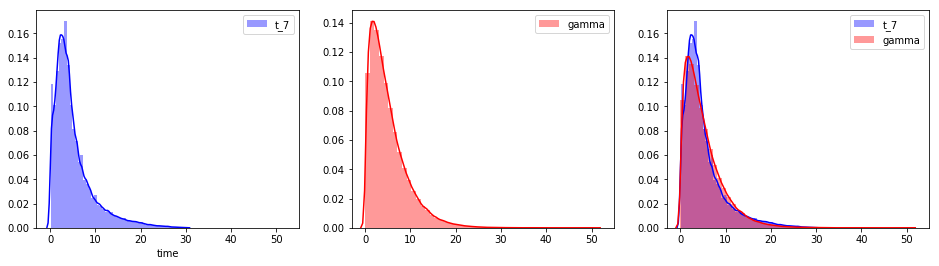

In [163]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
sns.distplot(t_7.time, color = 'blue', label='t_7')
plt.legend()
plt.xlim(-3,55)
#plt.ylim(0,0.025)

plt.subplot(1,3,2)
sns.distplot(y, color = 'red', label='gamma')
plt.legend()
plt.xlim(-3,55)
#plt.ylim(0,0.025)

plt.subplot(1,3,3)
sns.distplot(t_7, color = 'blue', label='t_7')
sns.distplot(y, color = 'red', label='gamma')
plt.legend()
plt.xlim(-3,55)

plt.show()
plt.close()

---

In [169]:
current

Timestamp('2018-08-01 00:00:00')

In [170]:
test_id[0]

'4,379,895'

In [173]:
(current - diaper_train[diaper_train.m_id == test_id[0]].iloc[-1].biz_dt).days/7

2.0

# # unit time 을 1주일로 변경!

In [174]:
# 함수로 출력되는게 많게했어! & unit time을 1주일로 변경.

def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days/7  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days/7
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days/7
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

---

In [153]:
t_7 = tt_drop0/7

In [154]:
stats.gamma.fit(t_7, floc=0)

(1.4696308007488543, 0, 3.4706943839102236)

In [175]:
alpha, _ , scale = stats.gamma.fit(t_7, floc=0)

In [178]:
for j in range(len(test_id_[:10])):
    for i in range(30):
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha , beta=1/scale , tmean = t_7.mean().item() , current=current_l[i])
        
        if i == 0:
            print('last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:])
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
    
    print('------------------------------------------------------------------------')
    print('\n')

last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 21.714285714285715 t_purch: 8.428571428571429
pred: 0.09688718528801532 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 21.857142857142858 t_purch: 8.428571428571429
pred: 0.09629133048692295 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 22.0 t_purch: 8.428571428571429
pred: 0.09570275341732837 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 22.142857142857142 t_purch: 8.428571428571429
pred: 0.09512132167645337 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 22.285714285714285 t_purch: 8.428571428571429
pred: 0.0945469060507983 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 22.428571428571427 t_purch: 8.428571428571429
pred: 0.09397938042078502 , tmean_u: 4.14285714

current: 2018-08-22 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.857142857142858
pred: 0.3637901596055433 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-23 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.857142857142858
pred: 0.3608326786017634 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-24 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.857142857142858
pred: 0.3579219109733188 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-25 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.857142857142858
pred: 0.3550567879860055 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-26 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.857142857142858
pred: 0.352236272085228 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-27 00:00:00 current-last_order: 4.0 t_purch: 25.857142857142858
pred: 0.3494593558268473 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-28 00:00:00 current-last_order: 4.

current: 2018-08-15 00:00:00 current-last_order: 12.857142857142858 t_purch: 18.857142857142858
pred: 0.15793066902486197 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-16 00:00:00 current-last_order: 13.0 t_purch: 18.857142857142858
pred: 0.1563560194618635 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-17 00:00:00 current-last_order: 13.142857142857142 t_purch: 18.857142857142858
pred: 0.1548123800334258 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-18 00:00:00 current-last_order: 13.285714285714286 t_purch: 18.857142857142858
pred: 0.15329884613600386 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-19 00:00:00 current-last_order: 13.428571428571429 t_purch: 18.857142857142858
pred: 0.1518145479080346 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-20 00:00:00 current-last_order: 13.571428571428571 t_purch: 18.857142857142858
pred: 0.15035864858325787 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-21 00:00:00 current-last_order: 13.71428

current: 2018-08-06 00:00:00 current-last_order: 10.428571428571429 t_purch: 0.0
pred: 0.2020113436011317 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 10.571428571428571 t_purch: 0.0
pred: 0.197416571667151 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 10.714285714285714 t_purch: 0.0
pred: 0.19302528826402499 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-09 00:00:00 current-last_order: 10.857142857142858 t_purch: 0.0
pred: 0.18882432966469054 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-10 00:00:00 current-last_order: 11.0 t_purch: 0.0
pred: 0.1848016380198002 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-11 00:00:00 current-last_order: 11.142857142857142 t_purch: 0.0
pred: 0.18094614823899347 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 11.285714285714286 t_purch: 0.0
pred: 0.17724768839673266 , tmean_u: 5.100639366580618 , k: 1 

cur

current: 2018-08-02 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.6050651805660548 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.567802124071606 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.571428571428571 t_purch: 0.0
pred: 0.5345084670462482 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 6.714285714285714 t_purch: 0.0
pred: 0.5046614595748927 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 6.857142857142857 t_purch: 0.0
pred: 0.477802283808897 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 7.0 t_purch: 0.0
pred: 0.45353630469610995 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 7.142857142857143 t_purch: 0.0
pred: 0.43152715724777313 , tmean_u: 5.100639366580618 , k: 1 

current: 2018

current: 2018-08-29 00:00:00 current-last_order: 8.571428571428571 t_purch: 0.0
pred: 0.28936401220908514 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-30 00:00:00 current-last_order: 8.714285714285714 t_purch: 0.0
pred: 0.28007519549815163 , tmean_u: 5.100639366580618 , k: 1 

------------------------------------------------------------------------


last order: 9742468   2018-06-01 07:35:15
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 8.571428571428571 t_purch: 21.571428571428573
pred: 0.23344031621973482 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 8.714285714285714 t_purch: 21.571428571428573
pred: 0.231626894480768 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 8.857142857142858 t_purch: 21.571428571428573
pred: 0.22984124776270332 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 9.0 t_purch: 21.571428571428573


In [201]:
diaper_train[diaper_train.m_id == test_id_[1]].biz_dt.tolist()

[Timestamp('2018-01-29 10:47:21'),
 Timestamp('2018-02-19 11:21:53'),
 Timestamp('2018-03-11 15:01:23'),
 Timestamp('2018-03-19 11:13:46'),
 Timestamp('2018-06-02 01:41:42'),
 Timestamp('2018-06-14 18:31:33'),
 Timestamp('2018-07-05 22:53:22'),
 Timestamp('2018-07-19 10:06:25'),
 Timestamp('2018-07-27 13:33:02'),
 Timestamp('2018-07-29 06:17:36'),
 Timestamp('2018-07-29 15:59:49')]

In [202]:
diaper_train[diaper_train.m_id == test_id_[1]].biz_dt.tolist()[0]

Timestamp('2018-01-29 10:47:21')

In [216]:
diaper_train[diaper_train.m_id == test_id_[1]].biz_dt.diff()

2789143                NaT
1609547   21 days 00:34:32
1043281   20 days 03:39:30
4593287    7 days 20:12:23
166122    74 days 14:27:56
6595913   12 days 16:49:51
6087440   21 days 04:21:49
3381826   13 days 11:13:03
7292969    8 days 03:26:37
7839251    1 days 16:44:34
7982559    0 days 09:42:13
Name: biz_dt, dtype: timedelta64[ns]

In [218]:
diaper_train[diaper_train.m_id == test_id_[1]].biz_dt.diff().mean().days

18

In [212]:
ll = [21,20,7,74,12,21,13,8,1,0]

In [214]:
sum(ll)/len(ll)

17.7

In [221]:
alpha

1.4696308007488543

In [223]:
beta = 1/scale

In [224]:
alpha/beta

5.100639366580533

---

In [179]:
# poisson 대입할때,  1/lambda로 해볼게.


for j in range(len(test_id_[:10])):
    for i in range(30):
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha , beta=1/scale , tmean = t_7.mean().item() , current=current_l[i])
        
        if i == 0:
            print('last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:])
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = 1/lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
    
    print('------------------------------------------------------------------------')
    print('\n')

last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 21.714285714285715 t_purch: 8.428571428571429
pred: 0.9999452531951449 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 21.857142857142858 t_purch: 8.428571428571429
pred: 0.9999486432928756 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 22.0 t_purch: 8.428571428571429
pred: 0.9999518234648826 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 22.142857142857142 t_purch: 8.428571428571429
pred: 0.9999548067104401 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 22.285714285714285 t_purch: 8.428571428571429
pred: 0.9999576052238653 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 22.428571428571427 t_purch: 8.428571428571429
pred: 0.9999602304443644 , tmean_u: 4.1428571428571

current: 2018-08-22 00:00:00 current-last_order: 3.2857142857142856 t_purch: 25.857142857142858
pred: 0.8904396421943407 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-23 00:00:00 current-last_order: 3.4285714285714284 t_purch: 25.857142857142858
pred: 0.892921436872669 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-24 00:00:00 current-last_order: 3.5714285714285716 t_purch: 25.857142857142858
pred: 0.8953470131801491 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-25 00:00:00 current-last_order: 3.7142857142857144 t_purch: 25.857142857142858
pred: 0.8977176445924833 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-26 00:00:00 current-last_order: 3.857142857142857 t_purch: 25.857142857142858
pred: 0.9000345757382132 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-27 00:00:00 current-last_order: 4.0 t_purch: 25.857142857142858
pred: 0.9022990230521751 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-28 00:00:00 current-last_order: 4.

current: 2018-08-16 00:00:00 current-last_order: 13.0 t_purch: 18.857142857142858
pred: 0.9972093995311169 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-17 00:00:00 current-last_order: 13.142857142857142 t_purch: 18.857142857142858
pred: 0.9973822024616564 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-18 00:00:00 current-last_order: 13.285714285714286 t_purch: 18.857142857142858
pred: 0.9975443048805549 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-19 00:00:00 current-last_order: 13.428571428571429 t_purch: 18.857142857142858
pred: 0.9976963693978098 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-20 00:00:00 current-last_order: 13.571428571428571 t_purch: 18.857142857142858
pred: 0.9978390175924826 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-21 00:00:00 current-last_order: 13.714285714285714 t_purch: 18.857142857142858
pred: 0.9979728325534658 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-22 00:00:00 current-last_order: 13.85714285

current: 2018-08-07 00:00:00 current-last_order: 10.571428571428571 t_purch: 0.0
pred: 0.989402307832712 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 10.714285714285714 t_purch: 0.0
pred: 0.9905601020971458 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-09 00:00:00 current-last_order: 10.857142857142858 t_purch: 0.0
pred: 0.9915914077320181 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-10 00:00:00 current-last_order: 11.0 t_purch: 0.0
pred: 0.9925100435770828 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-11 00:00:00 current-last_order: 11.142857142857142 t_purch: 0.0
pred: 0.9933283187685514 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 11.285714285714286 t_purch: 0.0
pred: 0.9940571976736914 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 11.428571428571429 t_purch: 0.0
pred: 0.9947064468063754 , tmean_u: 5.100639366580618 , k: 1 

current

current: 2018-08-03 00:00:00 current-last_order: 6.428571428571429 t_purch: 0.0
pred: 0.6964100496328374 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 6.571428571428571 t_purch: 0.0
pred: 0.729577148443258 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 6.714285714285714 t_purch: 0.0
pred: 0.7591207529905459 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 6.857142857142857 t_purch: 0.0
pred: 0.7854367287904036 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 7.0 t_purch: 0.0
pred: 0.8088776931855991 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 7.142857142857143 t_purch: 0.0
pred: 0.829757740194146 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-08-09 00:00:00 current-last_order: 7.285714285714286 t_purch: 0.0
pred: 0.8483566491694307 , tmean_u: 5.100639366580618 , k: 1 

current: 2018-0

last order: 9742468   2018-06-01 07:35:15
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 8.571428571428571 t_purch: 21.571428571428573
pred: 0.9767540111596997 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-02 00:00:00 current-last_order: 8.714285714285714 t_purch: 21.571428571428573
pred: 0.977525111428587 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-03 00:00:00 current-last_order: 8.857142857142858 t_purch: 21.571428571428573
pred: 0.9782706332792462 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-04 00:00:00 current-last_order: 9.0 t_purch: 21.571428571428573
pred: 0.9789914251817217 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-05 00:00:00 current-last_order: 9.142857142857142 t_purch: 21.571428571428573
pred: 0.9796883074611809 , tmean_u: 3.5714285714285716 , k: 7 

current: 2018-08-06 00:00:00 current-last_order: 9.285714285714286 t_purch: 21.571428571428573
pred: 0.9803620732315182 , tmean_u: 3.571428571

# ## 으아 여기까지 다 잘못된거다!!! -----------------------------------------------------


# ----------------------------------------------------------------------------------------

---

# <다시 시작!>

## * lambda라는 개념을 다시 잡기.
poisson(lambda) : 이때의 lambda는 단위시간 당 사건의 평균적인 발생 횟수. - 이를 추정하기 위해, 단위 시간 당 사건의 발생횟수의 분포를 본다.


## # 1/time 을 감마 피팅 하자.
: time들의 분포를 알고있다 -> 단위 시간 당, 사건의 발생횟수를 맞춰줄 수 있다. 예를 들어, user들로부터 t=(3일,4일,5일,6일)이라는 time-interval을 얻게 되었다고 하자.

 이때, 단위 시간 당 사건의 발생 횟수 X=(1/3, 1/4, 1/5, 1/6)이고, 이 분포를 이용해 poisson(lambda)를 추정하는 것이다.

In [247]:
# repeat purchase : 35일 -> 하루마다 약 0.028씩 구매사건이 일어난다!

1/35

0.02857142857142857

In [24]:
tt_drop0.mean()

time    35.704476
dtype: float64

In [25]:
# tt_drop0의 inverse를 사용할 것이다.

tt_inver = 1/tt_drop0

In [26]:
tt_inver

,time
2,0.043478
4,0.016949
6,0.032258
7,0.043478
8,0.016667
9,0.125000
11,0.018868
14,0.006757
15,0.031250
17,0.034483


In [27]:
tt_inver.mean()

time    0.07637
dtype: float64

In [28]:
1/tt_inver.mean()

time    13.094207
dtype: float64

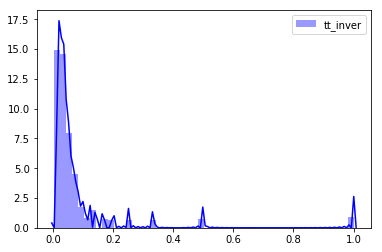

In [231]:
plt.figure()
sns.distplot( tt_inver, color = 'blue', label='tt_inver')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

In [60]:
alpha_, _ , scale_ = stats.gamma.fit(tt_inver, floc=0) 

In [61]:
y_ = stats.gamma.rvs(a = alpha_ , scale=scale_ , size = tt_drop0.shape[0])

In [70]:
(alpha_, 1/scale_)

(0.9303596940492564, 12.182322360944157)

In [63]:
y_.mean()

0.0765890684299771

In [65]:
1/y_.mean()

13.056693605227323

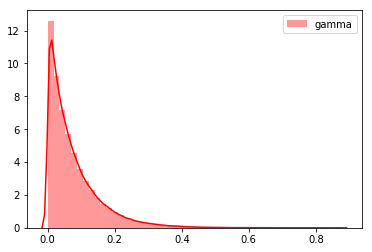

In [240]:
plt.figure()
sns.distplot( y_, color = 'red', label='gamma')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

In [241]:
# 함수로 출력되는게 많게했어!

def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

In [243]:
alpha_, scale_

(0.9303596940492564, 0.08208615487026874)

In [244]:
alpha_*(1/scale_)

11.333941704537422

In [245]:
1/scale_

12.182322360944157

In [242]:
for j in range(len(test_id_[:10])):
    for i in range(30):
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item() , current=current_l[i])
        
        if i == 0:
            print('last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:])
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
    
    print('------------------------------------------------------------------------')
    print('\n')

last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns]
current: 2018-08-01 00:00:00 current-last_order: 152 t_purch: 59
pred: 0.012315025765322951 , tmean_u: 29 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 153 t_purch: 59
pred: 0.012238333812655378 , tmean_u: 29 , k: 3 

current: 2018-08-03 00:00:00 current-last_order: 154 t_purch: 59
pred: 0.01216259113625151 , tmean_u: 29 , k: 3 

current: 2018-08-04 00:00:00 current-last_order: 155 t_purch: 59
pred: 0.012087780219835587 , tmean_u: 29 , k: 3 

current: 2018-08-05 00:00:00 current-last_order: 156 t_purch: 59
pred: 0.012013883975445117 , tmean_u: 29 , k: 3 

current: 2018-08-06 00:00:00 current-last_order: 157 t_purch: 59
pred: 0.011940885730418516 , tmean_u: 29 , k: 3 

current: 2018-08-07 00:00:00 current-last_order: 158 t_purch: 59
pred: 0.011868769214855246 , tmean_u: 29 , k: 3 

current: 2018-08-08 00:00:00 current-last_order: 159 t_purch: 59
pred: 0.011797518549526487 , tmean_u: 29 , k: 3 

cur

current: 2018-08-09 00:00:00 current-last_order: 151 t_purch: 0
pred: 0.007919754817699909 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-10 00:00:00 current-last_order: 152 t_purch: 0
pred: 0.007855298732049265 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-11 00:00:00 current-last_order: 153 t_purch: 0
pred: 0.007791883341780603 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 154 t_purch: 0
pred: 0.007729483644565716 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 155 t_purch: 0
pred: 0.007668075432605614 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-14 00:00:00 current-last_order: 156 t_purch: 0
pred: 0.007607635261318468 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-15 00:00:00 current-last_order: 157 t_purch: 0
pred: 0.007548140419496474 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-16 00:00:00 current-last_order: 158 t_purch: 0
pred: 0.007489568900853061

current: 2018-08-16 00:00:00 current-last_order: 17 t_purch: 11
pred: 0.07992632544857514 , tmean_u: 5 , k: 3 

current: 2018-08-17 00:00:00 current-last_order: 18 t_purch: 11
pred: 0.07680432948547689 , tmean_u: 5 , k: 3 

current: 2018-08-18 00:00:00 current-last_order: 19 t_purch: 11
pred: 0.07391694047461816 , tmean_u: 5 , k: 3 

current: 2018-08-19 00:00:00 current-last_order: 20 t_purch: 11
pred: 0.07123868385384724 , tmean_u: 5 , k: 3 

current: 2018-08-20 00:00:00 current-last_order: 21 t_purch: 11
pred: 0.0687476426993201 , tmean_u: 5 , k: 3 

current: 2018-08-21 00:00:00 current-last_order: 22 t_purch: 11
pred: 0.06642485790545671 , tmean_u: 5 , k: 3 

current: 2018-08-22 00:00:00 current-last_order: 23 t_purch: 11
pred: 0.06425384570932191 , tmean_u: 5 , k: 3 

current: 2018-08-23 00:00:00 current-last_order: 24 t_purch: 11
pred: 0.06222020663401795 , tmean_u: 5 , k: 3 

current: 2018-08-24 00:00:00 current-last_order: 25 t_purch: 11
pred: 0.06031130626875136 , tmean_u: 5 , 

current: 2018-08-20 00:00:00 current-last_order: 62 t_purch: 0
pred: 0.029362054724740405 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-21 00:00:00 current-last_order: 63 t_purch: 0
pred: 0.02849525344751147 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-22 00:00:00 current-last_order: 64 t_purch: 0
pred: 0.027678159268923808 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-23 00:00:00 current-last_order: 65 t_purch: 0
pred: 0.02690661592063326 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-24 00:00:00 current-last_order: 66 t_purch: 0
pred: 0.02617691791149579 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-25 00:00:00 current-last_order: 67 t_purch: 0
pred: 0.025485751031813164 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-26 00:00:00 current-last_order: 68 t_purch: 0
pred: 0.024830142037761682 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 69 t_purch: 0
pred: 0.0242074159049398 , tmean_u: 3

current: 2018-08-22 00:00:00 current-last_order: 53 t_purch: 0
pred: 0.0404304538818695 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-23 00:00:00 current-last_order: 54 t_purch: 0
pred: 0.038805164183666974 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-24 00:00:00 current-last_order: 55 t_purch: 0
pred: 0.03730548118216537 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-25 00:00:00 current-last_order: 56 t_purch: 0
pred: 0.035917387396008804 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-26 00:00:00 current-last_order: 57 t_purch: 0
pred: 0.034628876083645954 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 58 t_purch: 0
pred: 0.033429603222816295 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-28 00:00:00 current-last_order: 59 t_purch: 0
pred: 0.03231060934748453 , tmean_u: 35.704475566063735 , k: 1 

current: 2018-08-29 00:00:00 current-last_order: 60 t_purch: 0
pred: 0.031264095413898074 , tmean_u: 

---

# # 1주일 단위로

In [29]:
# 1주윌 단위로 계산 -> 하루 단위에서 7배 해주면 되지.

tt_inver7 = tt_inver*7

In [30]:
tt_inver7.time.value_counts()

0.350000    6597
0.500000    6597
0.333333    6572
0.466667    6335
0.411765    6236
0.388889    6232
0.538462    6209
0.368421    6181
0.259259    6042
0.437500    5940
0.250000    5882
0.318182    5860
0.304348    5682
0.269231    5579
0.291667    5531
0.583333    5476
0.280000    5429
0.241379    5348
7.000000    4994
0.636364    4833
0.233333    4809
0.700000    4765
0.225806    4498
0.777778    4374
0.875000    4236
0.218750    4166
1.000000    4122
0.212121    4075
3.500000    4018
0.205882    3960
            ... 
0.039773      45
0.037838      38
0.036269      37
0.038889      35
0.038043      34
0.040000      34
0.037634      30
0.036649      27
0.036458      26
0.036842      26
0.037433      25
0.036082      24
0.037037      24
0.037234      24
0.035533      21
0.035176      21
0.034314      18
0.035714      16
0.035000      15
0.034653      13
0.035897      13
0.035354      13
0.034826      12
0.034483      11
0.033981       9
0.034146       7
0.033333       6
0.033493      

In [94]:
print(tt_inver.shape[0], sum(tt_inver7.time == 7.0)  )  # 27만개중에, 약 5000개가 time-interval=1이야

# tt_invr7 == 7 이라는 의미는, 1주일 단위에 구매가 '7번'일어나는 사람들의 frequency를 보여주는거야!(사실은, 하루에 한번 산 사람들!) 

275764 4994


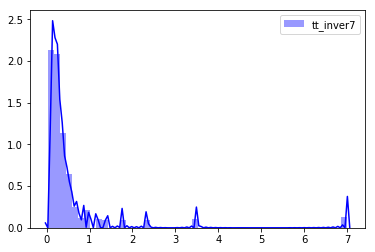

In [251]:
plt.figure()
sns.distplot( tt_inver7, color = 'blue', label='tt_inver7')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

In [31]:
alpha_, _ , scale_ = stats.gamma.fit(tt_inver7, floc=0) 

In [32]:
alpha_, scale_

(0.9303596940492559, 0.5746030840918818)

In [33]:
tt_inver7.mean()

time    0.534588
dtype: float64

In [37]:
alpha_*scale_   # tt_inver7.mean() == alpha_*scale_

0.5345875495154819

In [38]:
alpha_*scale_**2

0.3071756546687175

In [34]:
tt_inver7.var()

time    1.051183
dtype: float64

In [35]:
tt_inver7.var()/tt_inver7.mean()

time    1.966344
dtype: float64

- 일단, sample mean / variance로 gamma(alpha, beta)추정한 값이 차이가 크다....! 아무래도 감마피팅과 잘 안맞아보여서 그런가봐....!

In [40]:
y_ = stats.gamma.rvs(a = alpha_ , scale=scale_ , size = tt_drop0.shape[0])

In [41]:
(alpha_*scale_)

0.5345875495154819

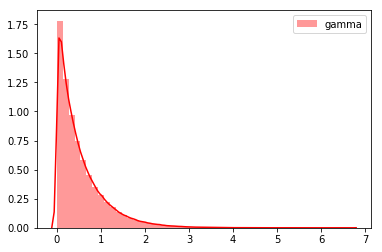

In [42]:
plt.figure()
sns.distplot( y_, color = 'red', label='gamma')
plt.legend()
#plt.xlim(-3,55)

plt.show()
plt.close()

In [43]:
# 함수로 출력되는게 많게했어! & unit time을 1주일로 변경.

def func_lamb(train, test, test_id, current, alpha, beta, tmean):
    t_ = (current - train[train.m_id == test_id].iloc[-1].biz_dt).days/7  # 구매이력이 없는사람은?(고려해야해) - 지금은 있는 사람만.
    t_purch = (train[train.m_id == test_id].iloc[-1].biz_dt - train[train.m_id == test_id].iloc[0].biz_dt).days/7
    k = train.biz_dt[train.m_id == test_id].shape[0] # train 구매이력
    if k <= 1 :
        tmean_u = tmean # tmean : 모든 user들의 상품에대한 평균 t(구매이력이 한번밖에 없으니, user의 고유 평균 t값 대입할 수 없다.)
    else:
        tmean_u = train.biz_dt[train.m_id == test_id].diff().mean().days/7
    lamb = (k+alpha)/(t_purch+2*abs(tmean_u-t_)+beta)
    return lamb, t_, t_purch, tmean_u, k

In [44]:
alpha_, 1/scale_

(0.9303596940492559, 1.7403317658491635)

In [59]:
# 설정한 current에서 한달 정도의 기간을 만들어준다.

current_l = pd.date_range('2018-08-01', periods=30).tolist()

In [60]:
d = {}

for j in range(len(test_id_[:30])):
    d[j] = []
    for i in range(30):     ## 8월 한달간에 대해서!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current=current_l[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )
    print('------------------------------------------------------------------------')
    print('\n')

user:[0] last order: 2272463   2018-07-17 09:49:11
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 2.4285714285714284 t_purch: 0.0
pred: 0.23850961614127175 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 2.5714285714285716 t_purch: 0.0
pred: 0.2471795141407469 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 2.7142857142857144 t_purch: 0.0
pred: 0.25649803131475946 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 2.85714285

current: 2018-08-25 00:00:00 current-last_order: 6.428571428571429 t_purch: 25.714285714285715
pred: 0.22108331573010487 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-26 00:00:00 current-last_order: 6.571428571428571 t_purch: 25.714285714285715
pred: 0.21934517405228993 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-27 00:00:00 current-last_order: 6.714285714285714 t_purch: 25.714285714285715
pred: 0.21763399483991852 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-28 00:00:00 current-last_order: 6.857142857142857 t_purch: 25.714285714285715
pred: 0.2159491595576083 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-29 00:00:00 current-last_order: 7.0 t_purch: 25.714285714285715
pred: 0.21429006830783603 , tmean_u: 4.285714285714286 , k: 7 

current: 2018-08-30 00:00:00 current-last_order: 7.142857142857143 t_purch: 25.714285714285715
pred: 0.21265613914010706 , tmean_u: 4.285714285714286 , k: 7 

-------------------------------------------------------------

current: 2018-08-15 00:00:00 current-last_order: 11.571428571428571 t_purch: 16.857142857142858
pred: 0.1488238364800467 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-16 00:00:00 current-last_order: 11.714285714285714 t_purch: 16.857142857142858
pred: 0.14755400513601558 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-17 00:00:00 current-last_order: 11.857142857142858 t_purch: 16.857142857142858
pred: 0.14630561136978426 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-18 00:00:00 current-last_order: 12.0 t_purch: 16.857142857142858
pred: 0.14507811815803495 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-19 00:00:00 current-last_order: 12.142857142857142 t_purch: 16.857142857142858
pred: 0.14387100621962223 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-20 00:00:00 current-last_order: 12.285714285714286 t_purch: 16.857142857142858
pred: 0.1426837732909063 , tmean_u: 5.571428571428571 , k: 4 

current: 2018-08-21 00:00:00 current-last_order: 12.4285

current: 2018-08-06 00:00:00 current-last_order: 5.857142857142857 t_purch: 16.285714285714285
pred: 0.22979443517822062 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-07 00:00:00 current-last_order: 6.0 t_purch: 16.285714285714285
pred: 0.2267911957748805 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-08 00:00:00 current-last_order: 6.142857142857143 t_purch: 16.285714285714285
pred: 0.22386496956423974 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-09 00:00:00 current-last_order: 6.285714285714286 t_purch: 16.285714285714285
pred: 0.22101285182925257 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-10 00:00:00 current-last_order: 6.428571428571429 t_purch: 16.285714285714285
pred: 0.21823208099017766 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-11 00:00:00 current-last_order: 6.571428571428571 t_purch: 16.285714285714285
pred: 0.21552002997325448 , tmean_u: 5.428571428571429 , k: 4 

current: 2018-08-12 00:00:00 current-last_order: 6.7142857142

current: 2018-08-28 00:00:00 current-last_order: 8.142857142857142 t_purch: 8.714285714285714
pred: 0.19452526540592474 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-29 00:00:00 current-last_order: 8.285714285714286 t_purch: 8.714285714285714
pred: 0.19182311280546016 , tmean_u: 4.285714285714286 , k: 3 

current: 2018-08-30 00:00:00 current-last_order: 8.428571428571429 t_purch: 8.714285714285714
pred: 0.1891946997020817 , tmean_u: 4.285714285714286 , k: 3 

------------------------------------------------------------------------


user:[7] last order: 5853334   2018-03-01 00:41:34
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 21.714285714285715 t_purch: 8.428571428571429
pred: 0.083084893532409 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-02 00:00:00 current-last_order: 21.857142857142858 t_purch: 8.428571428571429
pred: 0.08258639982038929 , tmean_u: 4.142857142857143 , k: 3 

current: 2018-08-03 00:00:00 current-last_order

current: 2018-08-19 00:00:00 current-last_order: 6.857142857142857 t_purch: 4.285714285714286
pred: 0.23077189079694926 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-20 00:00:00 current-last_order: 7.0 t_purch: 4.285714285714286
pred: 0.2257213397709218 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-21 00:00:00 current-last_order: 7.142857142857143 t_purch: 4.285714285714286
pred: 0.22088583491366898 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-22 00:00:00 current-last_order: 7.285714285714286 t_purch: 4.285714285714286
pred: 0.21625201597269927 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-23 00:00:00 current-last_order: 7.428571428571429 t_purch: 4.285714285714286
pred: 0.211807599065008 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-24 00:00:00 current-last_order: 7.571428571428571 t_purch: 4.285714285714286
pred: 0.2075412712901059 , tmean_u: 4.285714285714286 , k: 2 

current: 2018-08-25 00:00:00 current-last_order: 7.714285714285714 t_p

current: 2018-08-11 00:00:00 current-last_order: 1.4285714285714286 t_purch: 0.0
pred: 0.19143170171122925 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 1.5714285714285714 t_purch: 0.0
pred: 0.19699162531428416 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 1.7142857142857142 t_purch: 0.0
pred: 0.20288259233225814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-14 00:00:00 current-last_order: 1.8571428571428572 t_purch: 0.0
pred: 0.20913490088036135 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-15 00:00:00 current-last_order: 2.0 t_purch: 0.0
pred: 0.21578263579715118 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-16 00:00:00 current-last_order: 2.142857142857143 t_purch: 0.0
pred: 0.2228642739113429 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-17 00:00:00 current-last_order: 2.2857142857142856 t_purch: 0.0
pred: 0.23042340787342663 , tmean_u: 5.100639366580533 , k: 1 

cu

current: 2018-08-03 00:00:00 current-last_order: 0.5714285714285714 t_purch: 25.857142857142858
pred: 0.3144769824623592 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-04 00:00:00 current-last_order: 0.7142857142857143 t_purch: 25.857142857142858
pred: 0.31683474333735806 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-05 00:00:00 current-last_order: 0.8571428571428571 t_purch: 25.857142857142858
pred: 0.3192275943390589 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-06 00:00:00 current-last_order: 1.0 t_purch: 25.857142857142858
pred: 0.3216563096355093 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-07 00:00:00 current-last_order: 1.1428571428571428 t_purch: 25.857142857142858
pred: 0.32412168575435574 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-08 00:00:00 current-last_order: 1.2857142857142858 t_purch: 25.857142857142858
pred: 0.3266245423670687 , tmean_u: 2.5714285714285716 , k: 11 

current: 2018-08-09 00:00:00 current-last_order

current: 2018-08-26 00:00:00 current-last_order: 24.0 t_purch: 0.0
pred: 0.047648982723065836 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 24.142857142857142 t_purch: 0.0
pred: 0.047315353721247844 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-28 00:00:00 current-last_order: 24.285714285714285 t_purch: 0.0
pred: 0.04698636332859574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-29 00:00:00 current-last_order: 24.428571428571427 t_purch: 0.0
pred: 0.04666191549286214 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-30 00:00:00 current-last_order: 24.571428571428573 t_purch: 0.0
pred: 0.046341916795042404 , tmean_u: 5.100639366580533 , k: 1 

------------------------------------------------------------------------


user:[14] last order: 7058820   2018-07-26 23:17:51
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 0.7142857142857143 t_purch: 25.571428571428573
pred: 0.03732917756071052

current: 2018-08-17 00:00:00 current-last_order: 13.142857142857142 t_purch: 18.857142857142858
pred: 0.1308499822524236 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-18 00:00:00 current-last_order: 13.285714285714286 t_purch: 18.857142857142858
pred: 0.12961904009001934 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-19 00:00:00 current-last_order: 13.428571428571429 t_purch: 18.857142857142858
pred: 0.128411002934969 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-20 00:00:00 current-last_order: 13.571428571428571 t_purch: 18.857142857142858
pred: 0.12722523849638234 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-21 00:00:00 current-last_order: 13.714285714285714 t_purch: 18.857142857142858
pred: 0.12606113750007453 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-22 00:00:00 current-last_order: 13.857142857142858 t_purch: 18.857142857142858
pred: 0.12491811265277208 , tmean_u: 9.428571428571429 , k: 3 

current: 2018-08-23 00:00:00 current-last_o

current: 2018-08-07 00:00:00 current-last_order: 13.857142857142858 t_purch: 4.142857142857143
pred: 0.10932054907942412 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-08 00:00:00 current-last_order: 14.0 t_purch: 4.142857142857143
pred: 0.10816885938707221 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-09 00:00:00 current-last_order: 14.142857142857142 t_purch: 4.142857142857143
pred: 0.1070411555672327 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-10 00:00:00 current-last_order: 14.285714285714286 t_purch: 4.142857142857143
pred: 0.10593669689625018 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-11 00:00:00 current-last_order: 14.428571428571429 t_purch: 4.142857142857143
pred: 0.1048547728024215 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-12 00:00:00 current-last_order: 14.571428571428571 t_purch: 4.142857142857143
pred: 0.10379470134918267 , tmean_u: 4.142857142857143 , k: 2 

current: 2018-08-13 00:00:00 current-last_order: 14.7142857142

current: 2018-08-29 00:00:00 current-last_order: 4.285714285714286 t_purch: 1.5714285714285714
pred: 0.3133598059470979 , tmean_u: 0.7142857142857143 , k: 3 

current: 2018-08-30 00:00:00 current-last_order: 4.428571428571429 t_purch: 1.5714285714285714
pred: 0.3064583438739217 , tmean_u: 0.7142857142857143 , k: 3 

------------------------------------------------------------------------


user:[19] last order: 6118967   2018-05-24 01:48:24
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 9.714285714285714 t_purch: 0.0
pred: 0.16138643536417574 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 9.857142857142858 t_purch: 0.0
pred: 0.15763058023858967 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 10.0 t_purch: 0.0
pred: 0.15404512871147058 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 10.142857142857142 t_purch: 0.0
pred: 0.150618771

current: 2018-08-24 00:00:00 current-last_order: 24.714285714285715 t_purch: 0.0
pred: 0.04602627635977008 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-25 00:00:00 current-last_order: 24.857142857142858 t_purch: 0.0
pred: 0.04571490576934589 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-26 00:00:00 current-last_order: 25.0 t_purch: 0.0
pred: 0.04540771898122953 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-27 00:00:00 current-last_order: 25.142857142857142 t_purch: 0.0
pred: 0.045104632248832766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-28 00:00:00 current-last_order: 25.285714285714285 t_purch: 0.0
pred: 0.04480556404545999 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-29 00:00:00 current-last_order: 25.428571428571427 t_purch: 0.0
pred: 0.04451043499125251 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-30 00:00:00 current-last_order: 25.571428571428573 t_purch: 0.0
pred: 0.04421916778299795 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-20 00:00:00 current-last_order: 7.857142857142857 t_purch: 20.428571428571427
pred: 0.20698647177054175 , tmean_u: 4.0 , k: 6 

current: 2018-08-21 00:00:00 current-last_order: 8.0 t_purch: 20.428571428571427
pred: 0.20524282349749323 , tmean_u: 4.0 , k: 6 

current: 2018-08-22 00:00:00 current-last_order: 8.142857142857142 t_purch: 20.428571428571427
pred: 0.20352816520056605 , tmean_u: 4.0 , k: 6 

current: 2018-08-23 00:00:00 current-last_order: 8.285714285714286 t_purch: 20.428571428571427
pred: 0.20184178374207962 , tmean_u: 4.0 , k: 6 

current: 2018-08-24 00:00:00 current-last_order: 8.428571428571429 t_purch: 20.428571428571427
pred: 0.20018298904304133 , tmean_u: 4.0 , k: 6 

current: 2018-08-25 00:00:00 current-last_order: 8.571428571428571 t_purch: 20.428571428571427
pred: 0.19855111316505347 , tmean_u: 4.0 , k: 6 

current: 2018-08-26 00:00:00 current-last_order: 8.714285714285714 t_purch: 20.428571428571427
pred: 0.19694550943539146 , tmean_u: 4.0 , k: 6 


current: 2018-08-14 00:00:00 current-last_order: 11.0 t_purch: 20.571428571428573
pred: 0.15994576872209798 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-15 00:00:00 current-last_order: 11.142857142857142 t_purch: 20.571428571428573
pred: 0.15872570921235918 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-16 00:00:00 current-last_order: 11.285714285714286 t_purch: 20.571428571428573
pred: 0.15752407250250733 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-17 00:00:00 current-last_order: 11.428571428571429 t_purch: 20.571428571428573
pred: 0.1563404456419779 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-18 00:00:00 current-last_order: 11.571428571428571 t_purch: 20.571428571428573
pred: 0.15517442789207436 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-19 00:00:00 current-last_order: 11.714285714285714 t_purch: 20.571428571428573
pred: 0.15402563027939908 , tmean_u: 5.142857142857143 , k: 5 

current: 2018-08-20 00:00:00 current-last_order: 11.857

current: 2018-08-11 00:00:00 current-last_order: 4.714285714285714 t_purch: 0.0
pred: 0.536123793055775 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 4.857142857142857 t_purch: 0.0
pred: 0.5796517947398971 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 5.0 t_purch: 0.0
pred: 0.6299826662205766 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-14 00:00:00 current-last_order: 5.142857142857143 t_purch: 0.0
pred: 0.6528041377417765 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-15 00:00:00 current-last_order: 5.285714285714286 t_purch: 0.0
pred: 0.5993446293530069 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-16 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-17 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-

current: 2018-08-07 00:00:00 current-last_order: 5.428571428571429 t_purch: 0.0
pred: 0.5531773153814906 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-08 00:00:00 current-last_order: 5.571428571428571 t_purch: 0.0
pred: 0.5131359972593814 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-09 00:00:00 current-last_order: 5.714285714285714 t_purch: 0.0
pred: 0.47820111146735467 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-10 00:00:00 current-last_order: 5.857142857142857 t_purch: 0.0
pred: 0.4475251015359182 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-11 00:00:00 current-last_order: 6.0 t_purch: 0.0
pred: 0.42041633831105507 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-12 00:00:00 current-last_order: 6.142857142857143 t_purch: 0.0
pred: 0.39631328709607805 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-13 00:00:00 current-last_order: 6.285714285714286 t_purch: 0.0
pred: 0.37475947433076273 , tmean_u: 5.100639366580533 , k: 1 

current: 

In [101]:
# 설정한 current에서 한달 정도의 기간을 만들어준다.

current_l = pd.date_range('2018-08-01', periods=60).tolist()

In [103]:
# user[10] 에 대해서만 해볼게.

j=10

d[j] = []
for i in range(len(current_l)):     ## 8월 한달간에 대해서!
        lamb, t_, t_purch, tmean_u, k = func_lamb(train = diaper_train, test = diaper_test, test_id=test_id_[j], 
                  alpha = alpha_ , beta=1/scale_ , tmean = tt_drop0.mean().item()/7 , current=current_l[i])
        
        if i == 0:
            print('user:[{}]'.format(j),'last order:', diaper_train.biz_dt[diaper_train.m_id == test_id_[j]][-1:], '\n')
        print('current:',current_l[i], 'current-last_order:', t_ , 't_purch:', t_purch)  
        print('pred:',(1-stats.poisson.pmf(mu = lamb, k=0)),', tmean_u:',tmean_u,', k:',k ,'\n')
        d[j].append( (1-stats.poisson.pmf(mu = lamb, k=0)) )

user:[10] last order: 9109044   2018-07-31 23:58:04
Name: biz_dt, dtype: datetime64[ns] 

current: 2018-08-01 00:00:00 current-last_order: 0.0 t_purch: 0.0
pred: 0.1492609718844462 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-02 00:00:00 current-last_order: 0.14285714285714285 t_purch: 0.0
pred: 0.15262529603615016 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-03 00:00:00 current-last_order: 0.2857142857142857 t_purch: 0.0
pred: 0.1561443769006401 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-04 00:00:00 current-last_order: 0.42857142857142855 t_purch: 0.0
pred: 0.1598291112140694 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-05 00:00:00 current-last_order: 0.5714285714285714 t_purch: 0.0
pred: 0.16369143967784472 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-06 00:00:00 current-last_order: 0.7142857142857143 t_purch: 0.0
pred: 0.1677444745267762 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-08-07 00:00:00 current-last_order: 0.857142

current: 2018-09-28 00:00:00 current-last_order: 8.285714285714286 t_purch: 0.0
pred: 0.21180363281332593 , tmean_u: 5.100639366580533 , k: 1 

current: 2018-09-29 00:00:00 current-last_order: 8.428571428571429 t_purch: 0.0
pred: 0.20539396797631326 , tmean_u: 5.100639366580533 , k: 1 



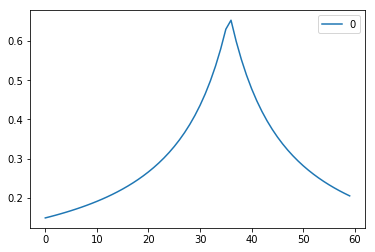

In [104]:
# user[10] : last-order가 7월 31일이다. 

sns.lineplot(data = pd.DataFrame(d[10]), color = 'red')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

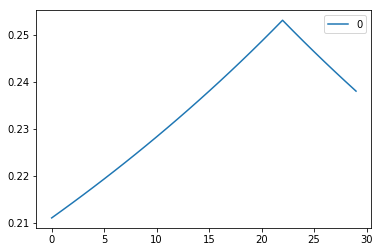

In [93]:
sns.lineplot(data = pd.DataFrame(d[9]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

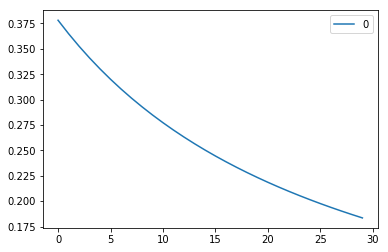

In [88]:
sns.lineplot(data = pd.DataFrame(d[4]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

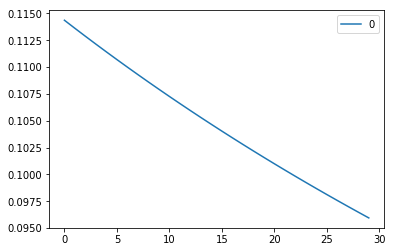

In [85]:
sns.lineplot(data = pd.DataFrame(d[2]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

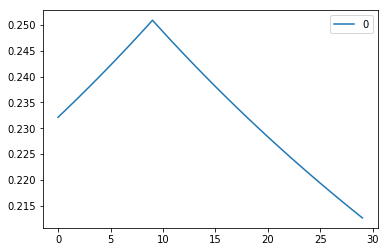

In [84]:
sns.lineplot(data = pd.DataFrame(d[1]), color = 'coral')
#plt.legend()
#plt.xlim(0,30)
#plt.ylim(0.15,0.4)

plt.show()
plt.close()

In [79]:
d[1][0]-d[1][1]

-0.0019459240906993802

In [80]:
d[1][1]-d[1][2]

-0.001978600028625599

In [81]:
d[1][2]-d[1][3]

-0.0020120991872238925

In [62]:
d[1]

[0.23211555328016686,
 0.23406147737086624,
 0.23604007739949184,
 0.23805217658671574,
 0.24009862576539054,
 0.24218030453386674,
 0.24429812246671057,
 0.24645302038611683,
 0.24864597169752223,
 0.25087798379315196,
 0.24864597169752223,
 0.24645302038611683,
 0.24429812246671057,
 0.24218030453386674,
 0.24009862576539054,
 0.23805217658671574,
 0.23604007739949184,
 0.23406147737086624,
 0.23211555328016686,
 0.2302015084198905,
 0.22831857154808555,
 0.2264659958893913,
 0.22464305818215957,
 0.22284905776923414,
 0.22108331573010487,
 0.21934517405228993,
 0.21763399483991852,
 0.2159491595576083,
 0.21429006830783603,
 0.21265613914010706]

In [284]:
y_.shape

(275764,)

In [285]:
y_.mean()

0.5346606211078251

In [289]:
(1/3+1/4+1/4)/3

0.27777777777777773

In [290]:
1/3

0.3333333333333333

In [295]:
tt_inver7.mean()

time    0.534588
dtype: float64

In [297]:
alpha_*scale_

0.5345875495154819

In [303]:
tt_inver.mean().values

array([0.07636965])

In [304]:
1/0.07636965

13.094206926442638

---

## * 왜 inverse로 추정하니,  35일에서 13일로 줄었느냐? 를 말해 줄 수 있다...

In [71]:
x = [2,2,2,2,2,2]
x = pd.DataFrame(x)

In [72]:
x.mean()

0    2.0
dtype: float64

In [73]:
x_inv = 1/x

In [74]:
x_inv.mean()

0    0.5
dtype: float64

In [80]:
1/x_inv.mean()

0    2.0
dtype: float64

In [77]:
y = [1,1,1,3,3,3]
y = pd.DataFrame(y)

In [78]:
y.mean()

0    2.0
dtype: float64

In [79]:
y_inv = 1/y
y_inv.mean()

0    0.666667
dtype: float64

In [81]:
1/y_inv.mean()

0    1.5
dtype: float64

---